In [ ]:
import pandas as pd
from transformers import pipeline
import ast
from mds_project.extracting_prompt import ExtractingPrompt
from LLM import LLM
from tqdm import tqdm
import re
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_onesymptom = pd.read_csv(r'dataset_generated_one_symptom_per_phrase.csv')

df_multi_predef = pd.read_csv(r'dataset_generated_multiple_symptoms_per_phrase_predefined_distrib.csv')
df_multi_poisson = pd.read_csv(r'dataset_generated_multiple_symptoms_per_phrase_poisson_distrib.csv')

df_multi_poisson_correl = pd.read_csv(r'dataset_generated_multiple_symptom_per_phrase_poisson_correlations.csv')

In [4]:
ctcae = pd.read_excel('PRO-CTCAE_Questionnaire_Terminology.xls', sheet_name = 'PRO')
symptoms_list = ctcae['PRO-CTCAE PT'].unique()[:-25]
symptoms_list = symptoms_list.tolist()  
symptoms_list.remove('Other Symptoms')

## Utility functions

In [5]:
def extract_symptom_scores(output_str):
    # This pattern matches a key enclosed in single or double quotes followed by a colon and a number (integer or float)
    pattern = r'["\']([^"\']+)["\']\s*:\s*([0-9]*\.?[0-9]+)'
    matches = re.findall(pattern, output_str)
    # Convert the extracted values to float and build the dictionary
    return {key: float(value) for key, value in matches}

## Import the LLM model : Biollama 

In [5]:
model = LLM(model_name="iRASC/BioLlama-Ko-8B", max_length=50)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Device set to use cuda:0


Model loaded on device(s): {'': 0}


In [5]:
# extractor = ExtractingPrompt(symptoms_list)

# results = []

# for i, phrase in tqdm(enumerate(df_multi_poisson['Dialogue_Generated'])):

#     prompt = extractor.build_extraction_prompt(phrase)

#     symptoms_extracted_llm = model.generate_text(messages=prompt)

#     # Extract symptoms with scores > 0.80
#     symptom_scores = extract_symptom_scores(symptoms_extracted_llm)

#     symptoms_extracted = [symptom for symptom, score in symptom_scores.items() if score > 0.60]

#     # Format the output appropriately
#     if len(symptoms_extracted) == 0:
#         formatted_symptoms = None  
#     elif len(symptoms_extracted) == 1:
#         formatted_symptoms = symptoms_extracted[0]  # single symptom as string
#     else:
#         formatted_symptoms = ", ".join(symptoms_extracted)  # multiple as comma-separated string
    

#     true_symptom = df_multi_poisson['Symptoms'][i]
    
#     results.append({
#         "Dialogue": phrase,
#         "True_Symptom": true_symptom,
#         "Extracted_Symptom": formatted_symptoms})
    
#     df_results = pd.DataFrame(results)

#     df_results.to_csv("dataset_extracting_multiple_symptoms_poisson.csv")

In [27]:
def calculate_accuracy(df_results):
    """
    Calculate accuracy of symptom extraction, case-insensitive and with proper handling of extracted symptoms.
    
    Args:
        df_results: DataFrame containing columns 'True_Symptom' and 'Extracted_Symptom'
        
    Returns:
        accuracy: Float between 0 and 1 representing match accuracy
    """
    score = 0
    total = len(df_results)
    
    if total == 0:
        return 0.0  # handle empty dataframe case
    
    for i in range(total):
        true_symptom = df_results.iloc[i]['True_Symptom']
        
        # Normalize and handle 'True_Symptom' as a list (if string representation of list, convert it)
        if isinstance(true_symptom, str):
            # If the true symptom is a string representation of a list, remove the surrounding quotes
            if true_symptom.startswith('[') and true_symptom.endswith(']'):
                true_symptom_list = [s.strip().strip("'").lower() for s in true_symptom[1:-1].split(',')]
            else:
                true_symptom_list = [true_symptom.strip().strip("'").lower()]
        elif isinstance(true_symptom, (list, tuple)):
            true_symptom_list = [str(s).strip().strip("'").lower() for s in true_symptom]
        else:
            true_symptom_list = [str(true_symptom).strip().strip("'").lower()]

        # Print to check the correct format
        print(true_symptom_list)

        try:
            # Safely handle the 'Extracted_Symptom' (assuming it might be a string representation of a list)
            extracted = df_results.iloc[i]['Extracted_Symptom']
            
            # Handle different possible formats:
            if isinstance(extracted, str):
                if extracted.startswith('[') and extracted.endswith(']'):
                    extracted_list = [s.strip().strip("'").lower() for s in extracted[1:-1].split(',')]
                else:
                    extracted_list = [extracted.strip().strip("'").lower()]

            elif isinstance(extracted, (list, tuple)):
                extracted_list = [str(s).strip().strip("'").lower() for s in extracted]
            else:
                extracted_list = [str(extracted).strip().strip("'").lower()]
            
            print(extracted_list)
            
            # Check if there is any intersection between true_symptom_list and extracted_list
            if any(symptom in extracted_list for symptom in true_symptom_list):
                score += 1
                
        except Exception as e:
            print(f"Error processing row {i}: {e}")
            continue
    
    accuracy = score / total
    return accuracy

In [13]:
true_symptom = (df_results['True_Symptom'])
true_symptom

0                                   ['Hives', 'Hiccups']
1      ['Ejaculation', 'Fecal incontinence', 'Ringing...
2                                        ['Watery eyes']
3                               ['Urinary incontinence']
4             ['Taste Changes', 'Unable to have orgasm']
                             ...                        
364    ['Abdominal pain', 'Discouraged', 'Chills', 'S...
365    ['Bloating', 'Numbness & tingling', 'Hot flash...
366    ['Vomiting', 'Breast swelling and tenderness',...
367    ['Bruising', 'Ringing in ears', 'Delayed orgas...
368                                          ['Anxious']
Name: True_Symptom, Length: 369, dtype: object

In [10]:
extracted = df_results['Extracted_Symptom']
extracted

0                                                Hiccups
1                                     Fecal incontinence
2                                            Watery eyes
3                                     Fecal incontinence
4                                          Taste Changes
                             ...                        
364    Abdominal pain, Bloating, Constipation, Decrea...
365                                Difficulty Swallowing
366                                     Nausea, Vomiting
367                            Bruising, Ringing in ears
368                                       Abdominal pain
Name: Extracted_Symptom, Length: 369, dtype: object

In [28]:
df_results = pd.read_csv("dataset_extracting_multiple_symptoms_poisson.csv") 
calculate_accuracy(df_results)

['hives', 'hiccups']
['hiccups']
['ejaculation', 'fecal incontinence', 'ringing in ears']
['fecal incontinence']
['watery eyes']
['watery eyes']
['urinary incontinence']
['fecal incontinence']
['taste changes', 'unable to have orgasm']
['taste changes']
['anxious']
['fatigue']
['fatigue']
['hand-foot syndrome (a rash of the hands and feet that can cause cracking, peeling, redness or pain)']
['muscle pain']
['abdominal pain']
['dry mouth', 'radiation skin reaction']
['dry mouth, radiation skin reaction']
['numbness & tingling', 'vaginal dryness', 'fecal incontinence']
['hand-foot syndrome (a rash of the hands and feet that can cause cracking, peeling, redness or pain)']
['memory']
['memory loss']
['nail ridging']
['nail discoloration, nail ridging, brittle nails, nail breakage']
['wheezing']
['wheezing']
['vomiting']
['abdominal pain']
['increased sweating']
['increased sweating']
['increased sweating']
['nausea']
['muscle pain']
['muscle pain']
['decreased sweating']
['decreased sweati

0.45257452574525747

In [14]:
df_results = pd.read_csv("dataset_extracting_multi_poisson_correl_explicit.csv") 
df_results

Dialogue  \
0    "I'm havin some issues, I got pain with the, u...   
1    "Oh no, I'm freaking out, I've been having the...   
2    "I've got this crazy dry mouth that's like sup...   
3    "As I wander through the twilight realm of my ...   
4    "I'm stuck with mild constipation, it's bloody...   
..                                                 ...   
995  "I am experiencing a change in my usuall urine...   
996  "I'm experiencing a change in my urine color, ...   
997  "The patient's condition is characterised by t...   
998  "These mouth/throat sores are an absolute nuis...   
999  "Mild afflictions beset my mouth and throat, s...   

                                          True_Symptom  \
0    ['Pain with sexual intercourse', 'Nail discolo...   
1    ['Nosebleed', 'Urinary incontinence', 'Constip...   
2    ['Dry Mouth', 'Cracking at the corners of the ...   
3    ['Achieve and maintain erection', 'Increased s...   
4                                     ['Constipation']   
..                                                 ...   
995  ['Change in usual urine color', 'Joint pain', ...   
996  ['Change in usual urine color', 'Nail loss', '...   
997                     ['Vaginal dryness', 'Fatigue']   
998                             ['Mouth/throat sores']   
999          ['Mouth/throat sores', 'Urinary urgency']   

                                     Extracted_Symptom  
0     Pain with sexual intercourse, Nail discoloration  
1        Nosebleed, Urinary incontinence, Constipation  
2    Difficulty Swallowing, Dry Mouth, Cracking at ...  
3    Difficulty Swallowing, Dry Mouth, Hoarseness, ...  
4         Difficulty Swallowing, Dry Mouth, Hoarseness  
..                                                 ...  
995  Decreased sweating, Breast swelling and tender...  
996  Decreased sweating, Nail loss, Change in usual...  
997                          Decreased libido, Fatigue  
998                                 Mouth/throat sores  
999  Difficulty Swallowing, Dry Mouth, Mouth/throat...  

[1000 rows x 3 columns]

In [15]:
df_results['Extracted_Symptom'] = df_results['Extracted_Symptom'].apply(lambda x: [s.strip() for s in str(x).split(',')])
df_results['Extracted_Symptom'] = df_results['Extracted_Symptom'].apply(lambda lst: str(lst))

df_results

Dialogue  \
0    "I'm havin some issues, I got pain with the, u...   
1    "Oh no, I'm freaking out, I've been having the...   
2    "I've got this crazy dry mouth that's like sup...   
3    "As I wander through the twilight realm of my ...   
4    "I'm stuck with mild constipation, it's bloody...   
..                                                 ...   
995  "I am experiencing a change in my usuall urine...   
996  "I'm experiencing a change in my urine color, ...   
997  "The patient's condition is characterised by t...   
998  "These mouth/throat sores are an absolute nuis...   
999  "Mild afflictions beset my mouth and throat, s...   

                                          True_Symptom  \
0    ['Pain with sexual intercourse', 'Nail discolo...   
1    ['Nosebleed', 'Urinary incontinence', 'Constip...   
2    ['Dry Mouth', 'Cracking at the corners of the ...   
3    ['Achieve and maintain erection', 'Increased s...   
4                                     ['Constipation']   
..                                                 ...   
995  ['Change in usual urine color', 'Joint pain', ...   
996  ['Change in usual urine color', 'Nail loss', '...   
997                     ['Vaginal dryness', 'Fatigue']   
998                             ['Mouth/throat sores']   
999          ['Mouth/throat sores', 'Urinary urgency']   

                                     Extracted_Symptom  
0    ['Pain with sexual intercourse', 'Nail discolo...  
1    ['Nosebleed', 'Urinary incontinence', 'Constip...  
2    ['Difficulty Swallowing', 'Dry Mouth', 'Cracki...  
3    ['Difficulty Swallowing', 'Dry Mouth', 'Hoarse...  
4    ['Difficulty Swallowing', 'Dry Mouth', 'Hoarse...  
..                                                 ...  
995  ['Decreased sweating', 'Breast swelling and te...  
996  ['Decreased sweating', 'Nail loss', 'Change in...  
997                    ['Decreased libido', 'Fatigue']  
998                             ['Mouth/throat sores']  
999  ['Difficulty Swallowing', 'Dry Mouth', 'Mouth/...  

[1000 rows x 3 columns]

In [ ]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, accuracy_score, 
    precision_score, recall_score, hamming_loss, f1_score, jaccard_score, 
    average_precision_score
)

def round_dict(d, ndigits=2):
    """
    Recursively rounds numeric values in a dictionary (or list/tuple) to 'ndigits' decimals.
    """
    if isinstance(d, dict):
        return {k: round_dict(v, ndigits) for k, v in d.items()}
    elif isinstance(d, (list, tuple)):
        return type(d)(round_dict(v, ndigits) for v in d)
    elif isinstance(d, (float, np.floating)):
        return round(float(d), ndigits)
    else:
        return d

class MultiLabelEvaluator:

    def __init__(self, y_true, y_pred, class_names=None, threshold=0.5, alpha=5, plot_confusion_matrices=False):

        """
        Evaluate multi-label classification performance using class-based metrics.
        
        Parameters:
            y_true (np.array): Binary array of shape (num_samples, num_classes) for ground truth.
            y_pred (np.array): Real-valued array (or probabilities) of shape (num_samples, num_classes).
            class_names (list): List of class names. If None, uses generic class labels.
            threshold (float): Threshold to convert y_pred to binary.
            alpha (float): Parameter for alpha-softmax/softmin aggregation.
        
        """

        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.class_names = class_names if class_names else [f"Class {i}" for i in range(self.y_true.shape[1])]
        self.threshold = threshold
        self.alpha = alpha
        self.y_pred_binary = (self.y_pred >= self.threshold).astype(int)

        # Compute confusion matrices for each class and display them.
        self.tps, self.fps, self.fns, self.tns = [], [], [], []
        num_labels = self.y_true.shape[1]
        
        if plot_confusion_matrices  :
            fig, axes = plt.subplots(1, num_labels, figsize=(4 * num_labels, 4))
            for c in range(num_labels):
                # Force 2x2 confusion matrix with labels [0, 1]
                cm = confusion_matrix(self.y_true[:, c], self.y_pred_binary[:, c], labels=[0, 1])
                self.tns.append(cm[0, 0])
                self.fps.append(cm[0, 1])
                self.fns.append(cm[1, 0])
                self.tps.append(cm[1, 1])
                ax = axes[c] if num_labels > 1 else axes
                sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=ax)
                ax.set_title(f"{self.class_names[c]}")
                ax.set_xlabel("Predicted")
                ax.set_ylabel("Actual")
            self.tps, self.fps, self.fns, self.tns = map(np.array, [self.tps, self.fps, self.fns, self.tns])
            plt.tight_layout()
            plt.show()

    def compute_binary_metrics(self):
        """Computes AUC, Accuracy, Precision, and Recall for each class."""
        aucs, accs, precs, recs = [], [], [], []
        for c in range(self.y_true.shape[1]):
            # aucs.append(roc_auc_score(self.y_true[:, c], self.y_pred[:, c]))
            accs.append(accuracy_score(self.y_true[:, c], self.y_pred_binary[:, c]))
            precs.append(precision_score(self.y_true[:, c], self.y_pred_binary[:, c], zero_division=1))
            recs.append(recall_score(self.y_true[:, c], self.y_pred_binary[:, c], zero_division=1))
        return np.array(aucs), np.array(accs), np.array(precs), np.array(recs)


    def aggregate_metrics(self, metrics):
        """
        Aggregates a list of metrics using average, alpha-softmax, and alpha-softmin.
        
        Returns a dictionary with aggregated values.
        """
        avg = np.mean(metrics)
        softmax = np.sum(metrics * np.exp(self.alpha * metrics)) / np.sum(np.exp(self.alpha * metrics))
        softmin = np.sum(metrics * np.exp(-self.alpha * metrics)) / np.sum(np.exp(-self.alpha * metrics))
        return {"Average": avg, "Alpha-Softmax": softmax, "Alpha-Softmin": softmin}


    def compute_false_distributions(self):
        """Computes false positive and false negative distributions per sample."""
        false_pos_per_sample = np.sum(self.y_pred_binary > self.y_true, axis=1)
        false_neg_per_sample = np.sum(self.y_pred_binary < self.y_true, axis=1)
        return {
            "Avg False Positives Over all samples": np.mean(false_pos_per_sample),
            "Avg False Negatives Over all samples": np.mean(false_neg_per_sample),
            "FP Distribution": false_pos_per_sample,
            "FN Distribution": false_neg_per_sample
        }

    def compute_work_saved(self):

        """Computes a work-saved metric indicating the proportion of corrections saved."""

        T1 = np.sum(self.y_true, axis=1)  # All positives (TP + FN)
        T2 = np.sum(self.y_pred_binary != self.y_true, axis=1)  # Corrections needed (FN + FP)
        work_saved = 1 - (T2 / np.maximum(T1, 1))  # Avoid division by zero
        return {"Avg Work Saved": np.mean(work_saved)}
    

    def overall_metrics(self):
        """Compute overall multi-label classification metrics."""
        
        overall = {
            
            "Hamming Loss": hamming_loss(self.y_true, self.y_pred_binary),
            "Micro F1-score": f1_score(self.y_true, self.y_pred_binary, average='micro'),
            "Macro F1-score": f1_score(self.y_true, self.y_pred_binary, average='macro'),
            "Weighted F1-score": f1_score(self.y_true, self.y_pred_binary, average='weighted'),
            "Jaccard Index (Macro)": jaccard_score(self.y_true, self.y_pred_binary, average='macro'),
            "Subset Accuracy": accuracy_score(self.y_true, self.y_pred_binary),
            "Mean Average Precision (MAP)": np.mean([
                average_precision_score(self.y_true[:, i], self.y_pred_binary[:, i]) 
                for i in range(self.y_true.shape[1]) if np.unique(self.y_true[:, i]).size > 1
            ])
        }
        return overall

    def evaluate(self):
        """Compute and return all class-based evaluation metrics."""
        aucs, accs, precs, recs = self.compute_binary_metrics()
        metrics = {
            # "AUC": self.aggregate_metrics(aucs),
            "Accuracy": self.aggregate_metrics(accs),
            "Precision": self.aggregate_metrics(precs),
            "Recall": self.aggregate_metrics(recs),
        }
        false_dist = self.compute_false_distributions()
        work_saved = self.compute_work_saved()
        overall = self.overall_metrics()
        return {
            "Class-Based Metrics": {**overall, **metrics, **false_dist, **work_saved}
        }


class SymptomMultiLabelEvaluator(MultiLabelEvaluator):
    def __init__(self, true_symptoms, extracted_symptoms, symptom_universe=None, threshold=0.5, alpha=5):
        """
        Adapts the MultiLabelEvaluator for symptom extraction evaluation using both class-based
        and sample-based metrics.
        
        Parameters:
            - true_symptoms: List of sets, each containing the true symptoms for a dialogue.
            - extracted_symptoms: List of sets, each containing the extracted symptoms.
            - symptom_universe: List of all possible symptoms. If None, computed as union of all sets.
            - threshold: Unused here (for compatibility) because we use binary sets.
            - alpha: Parameter for alpha-softmax/softmin aggregation.
        """
        self.true_symptom_sets = true_symptoms
        self.predicted_symptom_sets = extracted_symptoms

        if symptom_universe is None:
            symptom_universe = sorted(set().union(*true_symptoms, *extracted_symptoms))
        self.symptom_universe = symptom_universe

        # Convert the sets into binary matrices.
        y_true = self.sets_to_binary(true_symptoms, symptom_universe)
        y_pred = self.sets_to_binary(extracted_symptoms, symptom_universe)
        super().__init__(y_true, y_pred, class_names=symptom_universe, threshold=threshold, alpha=alpha)

    
    
    @staticmethod
    def sets_to_binary(sets_list, symptom_universe):
        """
        Converts a list of symptom sets into a binary numpy array.
        """
        num_samples = len(sets_list)
        num_symptoms = len(symptom_universe)
        binary_matrix = np.zeros((num_samples, num_symptoms), dtype=int)
        symptom_to_idx = {sym: idx for idx, sym in enumerate(symptom_universe)}
        for i, symptom_set in enumerate(sets_list):
            for sym in symptom_set:
                if sym in symptom_to_idx:
                    binary_matrix[i, symptom_to_idx[sym]] = 1
        return binary_matrix

    def compute_set_based_metrics(self):
        """
        Computes per-sample set-based metrics: Precision, Recall, F1, and Jaccard index.
        """
        precisions, recalls, f1s, jaccards = [], [], [], []
        for true_set, pred_set in zip(self.true_symptom_sets, self.predicted_symptom_sets):
            print(true_set , pred_set )
            true_set = set(true_set)
            pred_set = set(pred_set)

            if len(pred_set) == 0:
                
                precision = 1.0 if len(true_set) == 0 else 0.0
            else:
                precision = len(true_set.intersection(pred_set)) / len(pred_set)
            recall = len(true_set.intersection(pred_set)) / (len(true_set) if len(true_set) > 0 else 1)
            f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
            jaccard = len(true_set.intersection(pred_set)) / (len(true_set.union(pred_set)) if len(true_set.union(pred_set)) > 0 else 1)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            jaccards.append(jaccard)
        return {
            "Avg Precision (per sample)": np.mean(precisions),
            "Avg Recall (per sample)": np.mean(recalls),
            "Avg F1 (per sample)": np.mean(f1s),
            "Avg Jaccard (per sample)": np.mean(jaccards)
        }

    def evaluate(self):
        """
        Computes overall evaluation metrics, returning a dictionary with:
          - "Class-Based Metrics": Metrics computed from binary vectors.
          - "Sample-Based Metrics": Set-based (per dialogue) metrics.
        """
        base_evaluation = super().evaluate()["Class-Based Metrics"]
        set_based = self.compute_set_based_metrics()
        all_metrics = {
            "Class-Based Metrics": base_evaluation,
            "Sample-Based Metrics": set_based
        }
        # Round all numeric values to 2 decimals.
        return round_dict(all_metrics, ndigits=2)
    
def sets_to_binary(sets_list, symptom_universe):

    """
    Converts a list of symptom sets into a binary numpy array.
    """
    num_samples = len(sets_list)
    num_symptoms = len(symptom_universe)
    binary_matrix = np.zeros((num_samples, num_symptoms), dtype=int)
    symptom_to_idx = {sym: idx for idx, sym in enumerate(symptom_universe)}
    
    for i, symptom_set in enumerate(sets_list):
        for sym in symptom_set:
            if sym in symptom_to_idx:
                binary_matrix[i, symptom_to_idx[sym]] = 1
    
    return binary_matrix

In [ ]:
def evaluation_to_dataframe(evaluation_dict):
    """
    Flattens the nested evaluation output into a pandas DataFrame with columns:
    'metric', 'value', 'type'
    
    Parameters:
        evaluation_dict (dict): output of evaluator.evaluate()
    
    Returns:
        pd.DataFrame
    """
    rows = []
    for block_type, metrics in evaluation_dict.items():  # "Class-Based Metrics", "Sample-Based Metrics"
        for metric_name, value in metrics.items():
            if isinstance(value, dict):  # Aggregated metrics (e.g., AUC with Avg / Softmax / Softmin)
                for sub_metric, v in value.items():
                    rows.append({
                        "metric": f"{metric_name} ({sub_metric})",
                        "value": v,
                        "type": block_type.replace(" Metrics", "")
                    })
            else:
                rows.append({
                    "metric": metric_name,
                    "value": value,
                    "type": block_type.replace(" Metrics", "")
                })
    return pd.DataFrame(rows)

def Evaluation_pipeline(df) : 
    
    true_symptoms = [{ast.literal_eval(el)[i] for i in range(len(ast.literal_eval(el)))} for el in list(df['True_Symptom'])]
    extracted_symptoms = [{ast.literal_eval(el)[i] for i in range(len(ast.literal_eval(el)))} for el in list(df['Extracted_Symptom'])]
    evaluator = SymptomMultiLabelEvaluator(true_symptoms, extracted_symptoms)
    evaluation_results = evaluator.evaluate()

    df_metrics = evaluation_to_dataframe(evaluation_results)

    return df_metrics

In [ ]:
path = [r'dataset_extracting_multi_poisson_correl_explicit.csv',
        
        ]

all_datasets_results = {}

for path in path : 
   df_path = pd.read_csv(path)
   df_path['Extracted_Symptom'] = df_path['Extracted_Symptom'].apply(lambda x: [s.strip() for s in str(x).split(',')])
   df_path['Extracted_Symptom'] = df_path['Extracted_Symptom'].apply(lambda lst: str(lst))
   all_datasets_results[path] = Evaluation_pipeline(df_path)

{'Pain with sexual intercourse', 'Nail discoloration'} {'Pain with sexual intercourse', 'Nail discoloration'}
{'Urinary incontinence', 'Pain and swelling at injection site', 'Nosebleed', 'Constipation'} {'Urinary incontinence', 'Nosebleed', 'Constipation'}
{'Dry Mouth', 'Cracking at the corners of the mouth (cheilosis/cheilitis)'} {'Cracking at the corners of the mouth', 'Dry Mouth', 'Difficulty Swallowing'}
{'Achieve and maintain erection', 'Flashing lights', 'Increased sweating', 'Decreased libido'} {'Dry Mouth', 'Hoarseness', 'Mouth/throat sores', 'Difficulty Swallowing'}
{'Constipation'} {'Dry Mouth', 'Hoarseness', 'Difficulty Swallowing'}
{'Rash'} {'Rash'}
{'Headache'} {'Dry Mouth', 'Hoarseness', 'Mouth/throat sores', 'Difficulty Swallowing'}
{'Memory'} {'Dry Mouth', 'Hoarseness', 'Taste Changes', 'Difficulty Swallowing'}
{'Unable to have orgasm', 'Difficulty Swallowing', 'Chills', 'Nail discoloration'} {'Yellowing and discoloration of fingernails', 'Episodes of very severe chills

In [16]:
all_datasets_results[path]

metric  \
0                           Hamming Loss   
1                         Micro F1-score   
2                         Macro F1-score   
3                      Weighted F1-score   
4                  Jaccard Index (Macro)   
5                        Subset Accuracy   
6           Mean Average Precision (MAP)   
7                     Accuracy (Average)   
8               Accuracy (Alpha-Softmax)   
9               Accuracy (Alpha-Softmin)   
10                   Precision (Average)   
11             Precision (Alpha-Softmax)   
12             Precision (Alpha-Softmin)   
13                      Recall (Average)   
14                Recall (Alpha-Softmax)   
15                Recall (Alpha-Softmin)   
16  Avg False Positives Over all samples   
17  Avg False Negatives Over all samples   
18                       FP Distribution   
19                       FN Distribution   
20                        Avg Work Saved   
21            Avg Precision (per sample)   
22               Avg Recall (per sample)   
23                   Avg F1 (per sample)   
24              Avg Jaccard (per sample)   

                                                value          type  
0                                                0.01   Class-Based  
1                                                0.32   Class-Based  
2                                                0.08   Class-Based  
3                                                0.41   Class-Based  
4                                                0.05   Class-Based  
5                                                 0.2   Class-Based  
6                                                0.25   Class-Based  
7                                                0.99   Class-Based  
8                                                0.99   Class-Based  
9                                                0.98   Class-Based  
10                                               0.14   Class-Based  
11                                               0.85   Class-Based  
12                                               0.01   Class-Based  
13                                               0.88   Class-Based  
14                                               0.99   Class-Based  
15                                                0.3   Class-Based  
16                                               1.89   Class-Based  
17                                               1.19   Class-Based  
18  [0, 0, 2, 4, 3, 0, 4, 4, 3, 0, 0, 1, 3, 4, 0, ...   Class-Based  
19  [0, 1, 1, 4, 1, 0, 1, 1, 4, 0, 0, 1, 2, 1, 0, ...   Class-Based  
20                                              -0.82   Class-Based  
21                                               0.37  Sample-Based  
22                                                0.4  Sample-Based  
23                                               0.37  Sample-Based  
24                                               0.32  Sample-Based

In [45]:
df_path['Extracted_Symptom'][0]

"['Pain with sexual intercourse', 'Nail discoloration']"

In [46]:
df_path['True_Symptom'][0]

"['Pain with sexual intercourse', 'Nail discoloration']"

In [ ]:
# # Function to convert a string representation of a list to an actual list
# def parse_symptom_string(symptom_str):

#     if isinstance(symptom_str, str):
#             # If the true symptom is a string representation of a list, remove the surrounding quotes
#             if symptom_str.startswith('[') and symptom_str.endswith(']'):

#                 symptom_list = [s.strip().strip("'").lower() for s in symptom_str[1:-1].split(',')]
#             else:
#                 symptom_list = [symptom_str.strip().strip("'").lower()]

#             return symptom_list

#     elif isinstance(symptom_str, (list, tuple)):
            
#             symptom_list = [str(s).strip().strip("'").lower() for s in symptom_str]
#     else:
#             symptom_list = [str(symptom_str).strip().strip("'").lower()]
    
#     return symptom_list

def add_binary_columns(df_results, symptoms_list):
    
    y_true_binary = []
    y_pred_binary = []

    for _, row in df_results.iterrows():
        true_symptoms = df_results['True_Symptom']
        extracted_symptoms = df_results['Extracted_Symptom']

        # Create the binary vector for True Symptoms (y_true)
        true_vector = [1 if symptom.lower() in [s.lower() for s in true_symptoms] else 0 for symptom in symptoms_list]
        y_true_binary.append(true_vector)

        # Create the binary vector for Extracted Symptoms (y_pred)
        pred_vector = [1 if symptom.lower() in [s.lower() for s in extracted_symptoms] else 0 for symptom in symptoms_list]
        y_pred_binary.append(pred_vector)

    df_results['y_true_binary'] = y_true_binary
    df_results['y_pred_binary'] = y_pred_binary

    return df_results

df_results = add_binary_columns(df_results, symptoms_list)
df_results

Dialogue  \
0    "I'm havin some issues, I got pain with the, u...   
1    "Oh no, I'm freaking out, I've been having the...   
2    "I've got this crazy dry mouth that's like sup...   
3    "As I wander through the twilight realm of my ...   
4    "I'm stuck with mild constipation, it's bloody...   
..                                                 ...   
995  "I am experiencing a change in my usuall urine...   
996  "I'm experiencing a change in my urine color, ...   
997  "The patient's condition is characterised by t...   
998  "These mouth/throat sores are an absolute nuis...   
999  "Mild afflictions beset my mouth and throat, s...   

                                          True_Symptom  \
0    ['Pain with sexual intercourse', 'Nail discolo...   
1    ['Nosebleed', 'Urinary incontinence', 'Constip...   
2    ['Dry Mouth', 'Cracking at the corners of the ...   
3    ['Achieve and maintain erection', 'Increased s...   
4                                     ['Constipation']   
..                                                 ...   
995  ['Change in usual urine color', 'Joint pain', ...   
996  ['Change in usual urine color', 'Nail loss', '...   
997                     ['Vaginal dryness', 'Fatigue']   
998                             ['Mouth/throat sores']   
999          ['Mouth/throat sores', 'Urinary urgency']   

                                     Extracted_Symptom  \
0    ['Pain with sexual intercourse', 'Nail discolo...   
1    ['Nosebleed', 'Urinary incontinence', 'Constip...   
2    ['Difficulty Swallowing', 'Dry Mouth', 'Cracki...   
3    ['Difficulty Swallowing', 'Dry Mouth', 'Hoarse...   
4    ['Difficulty Swallowing', 'Dry Mouth', 'Hoarse...   
..                                                 ...   
995  ['Decreased sweating', 'Breast swelling and te...   
996  ['Decreased sweating', 'Nail loss', 'Change in...   
997                    ['Decreased libido', 'Fatigue']   
998                             ['Mouth/throat sores']   
999  ['Difficulty Swallowing', 'Dry Mouth', 'Mouth/...   

                                         y_true_binary  \
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
..                                                 ...   
995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
996  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
997  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
998  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
999  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                         y_pred_binary  
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
..                                                 ...  
995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
996  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
997  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
998  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
999  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[1000 rows x 5 columns]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    hamming_loss, jaccard_score, average_precision_score, confusion_matrix)


# - False Negatives (FN) are more dangerous than False Positives (FP) → Sensitivity & F2 Score are prioritized.
# - Specificity ensures minimal false alarms → avoids unnecessary tests/treatments

class MultiLabelEvaluator:

    def __init__(self, y_true, y_pred, class_names=None, alpha=5):

        """
        Initializes the evaluator with true labels and predicted probabilities.
        
        Parameters:

        - y_true: np.array, shape (N, C), true binary labels (0 or 1)
        - y_pred: np.array, shape (N, C), predicted probabilities
        - class_names: list, names of classes
        - threshold: float, probability threshold to convert to binary labels
        - alpha: float, parameter for alpha-Softmax/Softmin aggregation
    
        """

        self.y_true = y_true
        self.y_pred = y_pred
        self.class_names = class_names if class_names else [f"Class {i}" for i in range(self.y_true.shape[1])]
        self.alpha = alpha

        # Confusion matrix components for each class
        self.tps, self.fps, self.fns, self.tns = [], [], [], []
        num_labels = len(self.class_names)

        fig, axes = plt.subplots(1, num_labels, figsize=(4 * num_labels, 4))

        for c in range(num_labels):

            cm = confusion_matrix(y_true_array[:, c], y_pred_array[:, c])
            if cm.shape == (2, 2):  # Ensure that the confusion matrix has the expected shape
                self.tns.append(cm[0, 0])
                self.fps.append(cm[0, 1])
                self.fns.append(cm[1, 0])
                self.tps.append(cm[1, 1])

            else:
                # Handle cases where the confusion matrix is not 2x2 (e.g., only 0s or 1s)
                print(f"Confusion matrix for class {c} is not 2x2: {cm.shape}")
                # Here you can append zeros or handle the case as needed
                self.tns.append(0)
                self.fps.append(0)
                self.fns.append(0)
                self.tps.append(0)

                # cm = confusion_matrix(self.y_true[:, c], self.y_pred[:, c])

                # self.tns.append(cm[0, 0])
                # self.fps.append(cm[0, 1])
                # self.fns.append(cm[1, 0])
                # self.tps.append(cm[1, 1])

            ax = axes[c] if num_labels > 1 else axes

            sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=ax)

            ax.set_title(f"Label {c}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")

        self.tps, self.fps, self.fns, self.tns = map(np.array, [self.tps, self.fps, self.fns, self.tns])
        
        plt.tight_layout()
        plt.show()

    def compute_binary_metrics(self):

        """Computes AUC, Accuracy, Precision, Recall for each class."""

        aucs, accs, precs, recs = [], [], [], []
        for c in range(len(self.class_names)):
            # aucs.append(roc_auc_score(self.y_true[:, c], self.y_pred[:, c]))
            accs.append(accuracy_score(self.y_true[:, c], self.y_pred[:, c]))
            precs.append(precision_score(self.y_true[:, c], self.y_pred[:, c], zero_division=1))
            recs.append(recall_score(self.y_true[:, c], self.y_pred[:, c], zero_division=1))
        return np.array(aucs), np.array(accs), np.array(precs), np.array(recs)

    def aggregate_metrics(self, metrics):

        """Computes average, alpha-Softmax, and alpha-Softmin for a given metric set."""

        avg = np.mean(metrics)
        softmax = np.sum(metrics * np.exp(self.alpha * metrics)) / np.sum(np.exp(self.alpha * metrics))
        softmin = np.sum(metrics * np.exp(-self.alpha * metrics)) / np.sum(np.exp(-self.alpha * metrics))
        return {"Average": avg, "Alpha-Softmax": softmax, "Alpha-Softmin": softmin}

    def compute_false_distributions(self):

        """Computes false positive & false negative distributions across all samples."""

        false_pos_per_sample = np.sum(self.y_pred > self.y_true, axis=1)
        false_neg_per_sample = np.sum(self.y_pred < self.y_true, axis=1)
        return {
            "Avg False Positives Over all samples": np.mean(false_pos_per_sample),
            "Avg False Negatives Over all samples": np.mean(false_neg_per_sample),
            "FP Distribution": false_pos_per_sample,
            "FN Distribution": false_neg_per_sample
        }

    def compute_work_saved(self):

        """Computes the work saved metric."""

        T1 = np.sum(self.y_true, axis=1)  # All Positives (TP + FN)
        T2 = np.sum(self.y_pred != self.y_true, axis=1)  # FN + FP (corrections needed)
        work_saved = 1 - (T2 / np.maximum(T1, 1))  # Avoid division by zero
        return {"Avg Work Saved": np.mean(work_saved)}
    
    def overall_metrics(self):

        """Compute overall multi-label classification metrics, including MAP."""
        
        Overall_metrics ={
            "Hamming Loss": hamming_loss(self.y_true, self.y_pred),
            "Micro F1-score": f1_score(self.y_true, self.y_pred, average='micro'),
            "Macro F1-score": f1_score(self.y_true, self.y_pred, average='macro'),
            "Weighted F1-score": f1_score(self.y_true, self.y_pred, average='weighted'),
            "Jaccard Index (Macro)": jaccard_score(self.y_true, self.y_pred, average='macro'),
            "Subset Accuracy": accuracy_score(self.y_true, self.y_pred),
            "Mean Average Precision (MAP)": np.mean([
                average_precision_score(self.y_true[:, i], self.y_pred[:, i]) 
                for i in range(self.y_true.shape[1]) if np.unique(self.y_true[:, i]).size > 1
            ])
        }
        return Overall_metrics
    
    def evaluate(self):

        """Computes and prints all evaluation metrics."""

        aucs, accs, precs, recs = self.compute_binary_metrics()
        metrics = {
            # "AUC": self.aggregate_metrics(aucs),
            "Accuracy": self.aggregate_metrics(accs),
            "Precision": self.aggregate_metrics(precs),
            "Recall": self.aggregate_metrics(recs),
        }
        false_distributions = self.compute_false_distributions()
        work_saved = self.compute_work_saved()
        overall_metrics = self.overall_metrics()

        return {**overall_metrics, **metrics, **false_distributions, **work_saved}


y_true_array = np.array(df_results['y_true_binary'].tolist())
y_pred_array = np.array(df_results['y_pred_binary'].tolist())

evaluator = MultiLabelEvaluator(y_true_array, y_pred_array, class_names=symptoms_list)

results = evaluator.evaluate()
for key, value in results.items():
    print(f"{key}: {value}")

Confusion matrix for class 52 is not 2x2: (1, 1)
Confusion matrix for class 53 is not 2x2: (1, 1)
Confusion matrix for class 54 is not 2x2: (1, 1)
Confusion matrix for class 55 is not 2x2: (1, 1)
Confusion matrix for class 56 is not 2x2: (1, 1)
Confusion matrix for class 57 is not 2x2: (1, 1)
Confusion matrix for class 58 is not 2x2: (1, 1)
Confusion matrix for class 59 is not 2x2: (1, 1)
Confusion matrix for class 60 is not 2x2: (1, 1)
Confusion matrix for class 61 is not 2x2: (1, 1)
Confusion matrix for class 62 is not 2x2: (1, 1)
Confusion matrix for class 63 is not 2x2: (1, 1)
Confusion matrix for class 64 is not 2x2: (1, 1)
Confusion matrix for class 65 is not 2x2: (1, 1)
Confusion matrix for class 66 is not 2x2: (1, 1)
Confusion matrix for class 67 is not 2x2: (1, 1)
Confusion matrix for class 68 is not 2x2: (1, 1)
Confusion matrix for class 69 is not 2x2: (1, 1)
Confusion matrix for class 70 is not 2x2: (1, 1)
Confusion matrix for class 71 is not 2x2: (1, 1)
Confusion matrix for

KeyboardInterrupt: 

: 

In [102]:
y_true_array = np.array(df_results['y_true_binary'].tolist())
y_pred_array = np.array(df_results['y_pred_binary'].tolist())

y_true_array.shape

(1855, 80)

In [94]:
len(df_results)

369

In [93]:
l = df_results[df_results['y_pred_binary']==df_results['y_true_binary']]
l

Unnamed: 0                                           Dialogue  \
2             2  "I'm experiencing watery eyes that severely in...   
12           12  "Severe wheezing: Loud, raspy breathin sounds,...   
14           14  "Yer know, doc, I've been sweatin' like a pig ...   
16           16  "Muscle pain - achin all the time, makin it ha...   
17           17  "I have been experiencing a noticeable reducti...   
..          ...                                                ...   
329         329  "I've been experiencing almost constant severe...   
330         330  "I'm experiencing some issues with my mouth, b...   
332         332  "My skin is completly fine, no darkening or so...   
340         340  "Me, man, I got this thing goin' on down there...   
351         351  "I'm havin a bloody melt down every 5 minutes ...   

               True_Symptom   Extracted_Symptom  \
2           ['Watery eyes']         Watery eyes   
12             ['Wheezing']            Wheezing   
14   ['Increased sweating']  Increased sweating   
16          ['Muscle pain']         Muscle pain   
17   ['Decreased sweating']  Decreased sweating   
..                      ...                 ...   
329             ['Hiccups']             Hiccups   
330           ['Dry Mouth']           Dry Mouth   
332      ['Skin darkening']      Skin darkening   
340     ['Vaginal dryness']     Vaginal dryness   
351         ['Hot flashes']         Hot flashes   

                                         y_true_binary  \
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
12   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
14   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
16   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
17   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
..                                                 ...   
329  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
330  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
332  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
340  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
351  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                         y_pred_binary  
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
12   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
14   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
16   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
17   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
..                                                 ...  
329  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  
330  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
332  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
340  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
351  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[82 rows x 6 columns]

In [82]:
import numpy as np

# Assuming df['y_true_binary'] is your pandas Series containing lists
y_true = df_results['y_true_binary'].tolist()  # Convert pandas Series to list of lists

# Convert the list of lists into a numpy array
y_true_array = np.array(y_true)

# Check the shape of the resulting array
print(y_true_array.shape)  # Should be (369, C), where C is the length of each list

y_true_array

(369, 80)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [87]:
y_true_array[:,1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
true_symptoms = [{el} for el in list(df_results['True_Symptom'])]
extracted_symptoms = [{ast.literal_eval(el)[i] for i in range(len(ast.literal_eval(el)))} for el in list(df_results['Extracted_Symptom'])]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    hamming_loss, jaccard_score, average_precision_score, confusion_matrix
)

class MultiLabelEvaluator:
    def _init_(self, y_true, y_pred, class_names=None, threshold=0.5, alpha=5):
        
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.class_names = class_names if class_names else [f"Class {i}" for i in range(self.y_true.shape[1])]
        self.threshold = threshold
        self.alpha = alpha
        self.y_pred_binary = (self.y_pred >= self.threshold).astype(int)

        # Confusion matrix components for each class
        self.tps, self.fps, self.fns, self.tns = [], [], [], []
        num_labels = self.y_true.shape[1]
        fig, axes = plt.subplots(1, num_labels, figsize=(4 * num_labels, 4))
        for c in range(num_labels):
            # Specify labels to force a 2x2 confusion matrix
            cm = confusion_matrix(self.y_true[:, c], self.y_pred_binary[:, c], labels=[0, 1])
            self.tns.append(cm[0, 0])
            self.fps.append(cm[0, 1])
            self.fns.append(cm[1, 0])
            self.tps.append(cm[1, 1])
            ax = axes[c] if num_labels > 1 else axes
            sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=ax)
            ax.set_title(f"{self.class_names[c]}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")

        self.tps, self.fps, self.fns, self.tns = map(np.array, [self.tps, self.fps, self.fns, self.tns])
        plt.tight_layout()
        plt.show()


    def compute_binary_metrics(self):
        """Computes AUC, Accuracy, Precision, Recall for each class."""
        aucs, accs, precs, recs = [], [], [], []
        for c in range(self.y_true.shape[1]):
            aucs.append(roc_auc_score(self.y_true[:, c], self.y_pred[:, c]))
            accs.append(accuracy_score(self.y_true[:, c], self.y_pred_binary[:, c]))
            precs.append(precision_score(self.y_true[:, c], self.y_pred_binary[:, c], zero_division=1))
            recs.append(recall_score(self.y_true[:, c], self.y_pred_binary[:, c], zero_division=1))
        return np.array(aucs), np.array(accs), np.array(precs), np.array(recs)

    def aggregate_metrics(self, metrics):
        """Computes average, alpha-Softmax, and alpha-Softmin for a given metric set."""
        avg = np.mean(metrics)
        softmax = np.sum(metrics * np.exp(self.alpha * metrics)) / np.sum(np.exp(self.alpha * metrics))
        softmin = np.sum(metrics * np.exp(-self.alpha * metrics)) / np.sum(np.exp(-self.alpha * metrics))
        return {"Average": avg, "Alpha-Softmax": softmax, "Alpha-Softmin": softmin}

    def compute_false_distributions(self):
        """Computes false positive & false negative distributions across all samples."""
        false_pos_per_sample = np.sum(self.y_pred_binary > self.y_true, axis=1)
        false_neg_per_sample = np.sum(self.y_pred_binary < self.y_true, axis=1)
        return {
            "Avg False Positives Over all samples": np.mean(false_pos_per_sample),
            "Avg False Negatives Over all samples": np.mean(false_neg_per_sample),
            "FP Distribution": false_pos_per_sample,
            "FN Distribution": false_neg_per_sample
        }

    def compute_work_saved(self):
        """Computes the work saved metric."""
        T1 = np.sum(self.y_true, axis=1)  # All Positives (TP + FN)
        T2 = np.sum(self.y_pred_binary != self.y_true, axis=1)  # FN + FP (corrections needed)
        work_saved = 1 - (T2 / np.maximum(T1, 1))  # Avoid division by zero
        return {"Avg Work Saved": np.mean(work_saved)}
    
    def overall_metrics(self):
        """Compute overall multi-label classification metrics, including MAP."""
        overall_metrics = {
            "Hamming Loss": hamming_loss(self.y_true, self.y_pred_binary),
            "Micro F1-score": f1_score(self.y_true, self.y_pred_binary, average='micro'),
            "Macro F1-score": f1_score(self.y_true, self.y_pred_binary, average='macro'),
            "Weighted F1-score": f1_score(self.y_true, self.y_pred_binary, average='weighted'),
            "Jaccard Index (Macro)": jaccard_score(self.y_true, self.y_pred_binary, average='macro'),
            "Subset Accuracy": accuracy_score(self.y_true, self.y_pred_binary),
            "Mean Average Precision (MAP)": np.mean([
                average_precision_score(self.y_true[:, i], self.y_pred_binary[:, i]) 
                for i in range(self.y_true.shape[1]) if np.unique(self.y_true[:, i]).size > 1
            ])
        }
        return overall_metrics
    
    def evaluate(self):
        """Computes and returns all evaluation metrics."""
        aucs, accs, precs, recs = self.compute_binary_metrics()
        metrics = {
            "AUC": self.aggregate_metrics(aucs),
            "Accuracy": self.aggregate_metrics(accs),
            "Precision": self.aggregate_metrics(precs),
            "Recall": self.aggregate_metrics(recs),
        }
        false_distributions = self.compute_false_distributions()
        work_saved = self.compute_work_saved()
        overall_metrics = self.overall_metrics()
        return {**overall_metrics, **metrics, **false_distributions, **work_saved}


class SymptomMultiLabelEvaluator(MultiLabelEvaluator):
    def _init_(self, true_symptoms, extracted_symptoms, symptom_universe=None, threshold=0.5, alpha=5):
        """
        Adapts the MultiLabelEvaluator to work directly with sets of symptoms.
        
        Parameters:
            - true_symptoms: list of sets, each containing the true symptoms for a sentence.
            - extracted_symptoms: list of sets, each containing the symptoms extracted by the model.
            - symptom_universe: list of all possible symptoms. If None, it is computed as the union of all symptoms.
            - threshold: unused here (kept for compatibility), since we already have binary predictions.
            - alpha: parameter for alpha-softmax/softmin aggregation.
        """
        self.true_symptom_sets = true_symptoms
        self.predicted_symptom_sets = extracted_symptoms
        
        if symptom_universe is None:
            # Compute the union of all symptoms from both true and predicted sets
            symptom_universe = sorted(set().union(*true_symptoms, *extracted_symptoms))
        self.symptom_universe = symptom_universe
        
        # Convert sets to binary vectors
        y_true = self.sets_to_binary(true_symptoms, symptom_universe)
        y_pred = self.sets_to_binary(extracted_symptoms, symptom_universe)
        super()._init_(y_true, y_pred, class_names=symptom_universe, threshold=threshold, alpha=alpha)

    @staticmethod
    def sets_to_binary(sets_list, symptom_universe):
        """
        Converts a list of symptom sets into a binary matrix.
        
        Parameters:
            - sets_list: list of sets (true or predicted symptoms).
            - symptom_universe: list of all possible symptoms.
        
        Returns:
            - A binary numpy array of shape (number_of_samples, number_of_symptoms)
        """
        num_samples = len(sets_list)
        num_symptoms = len(symptom_universe)
        binary_matrix = np.zeros((num_samples, num_symptoms), dtype=int)
        symptom_to_idx = {sym: idx for idx, sym in enumerate(symptom_universe)}
        
        for i, symptom_set in enumerate(sets_list):
            for sym in symptom_set:
                if sym in symptom_to_idx:
                    binary_matrix[i, symptom_to_idx[sym]] = 1
        return binary_matrix



# Instantiate the evaluator for symptom extraction
evaluator = SymptomMultiLabelEvaluator(true_symptoms, extracted_symptoms)
results = evaluator.evaluate()
    
# Print the evaluation results
for key, value in results.items():
    print(f"{key}: {value}")

In [ ]:
for i in len(y_true_array.shape):
    print()

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

In [ ]:
df_results = pd.read_csv("Final_Extracting_one_symptom.csv") 
calculate_accuracy(df_results)

0.8141660319878141

In [18]:
model = LLM(model_name="meta-llama/Llama-3.2-3B-Instruct", max_length=50)

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cuda:0


Model loaded on device(s): {'': 0}


In [ ]:
extractor = ExtractingPrompt(symptoms_list)

results = []

for i, phrase in tqdm(enumerate(df['Dialogue_Generated'])):

    prompt = extractor.build_extraction_prompt(phrase)

    symptoms_extracted_llm = model.generate_text(messages=prompt)

    # Extract symptoms with scores > 0.80
    symptom_scores = extract_symptom_scores(symptoms_extracted_llm)

    symptoms_extracted = [symptom for symptom, score in symptom_scores.items() if score > 0.80]

    # Format the output appropriately
    if len(symptoms_extracted) == 0:
        formatted_symptoms = None  # or "" if you prefer empty string
    elif len(symptoms_extracted) == 1:
        formatted_symptoms = symptoms_extracted[0]  # single symptom as string
    else:
        formatted_symptoms = ", ".join(symptoms_extracted)  # multiple as comma-separated string
    

    true_symptom = df['Symptom'][i]
    
    results.append({
        "Dialogue": phrase,
        "True_Symptom": true_symptom,
        "Extracted_Symptom": formatted_symptoms})
    
    df_results = pd.DataFrame(results)

    # df_results.to_csv("Final_Extracting_one_symptom_llama7b.csv")

10it [00:19,  1.93s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
452it [13:15,  1.52s/it]

In [3]:
df_results = pd.read_csv("/home/laajila/mima_newcode/clean_code/symptom_extraction_meta-llama_Llama-3.2-3B-Instruct.csv")

In [4]:
calculate_accuracy(df_results)

0.4546839299314547

In [ ]:
import string

string(d)

d[3:]

'one_symptom'

Running the evaluation sensibility for  multi_poisson_correl  and prompting method :  explicit
The meta data we check is :  Language_Style


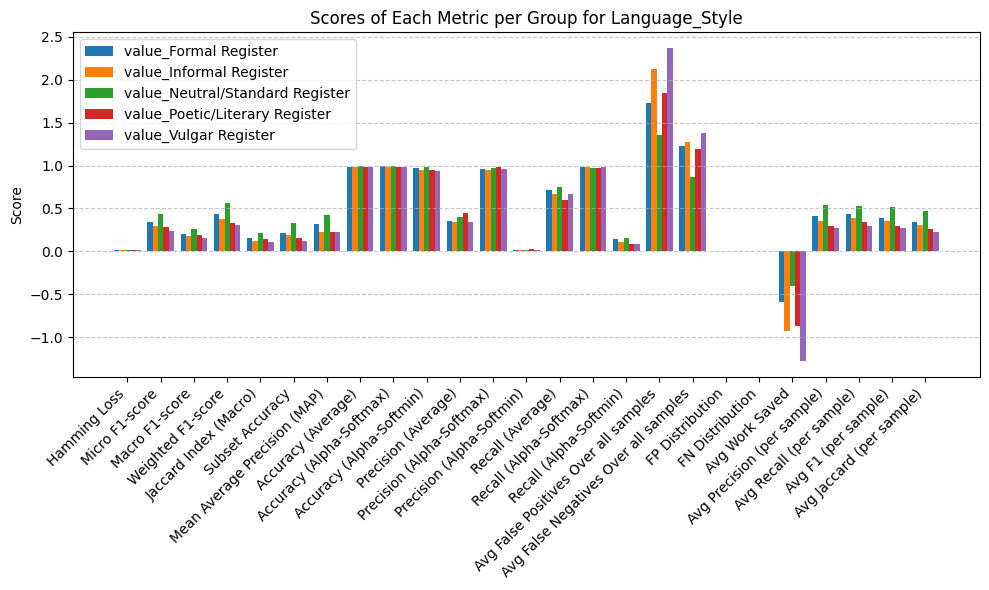

The meta data we check is :  Tone


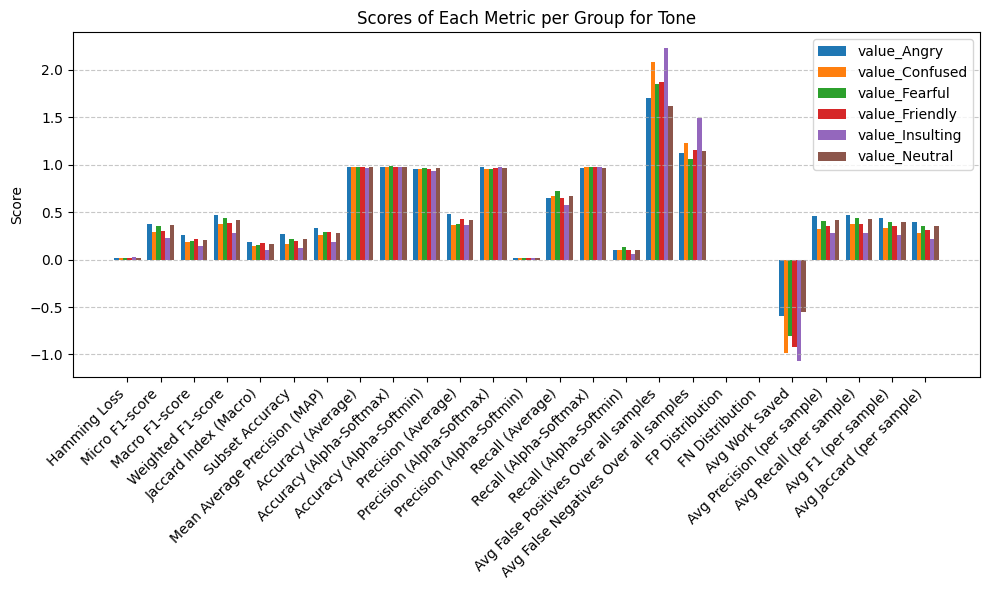

The meta data we check is :  Detail_Level


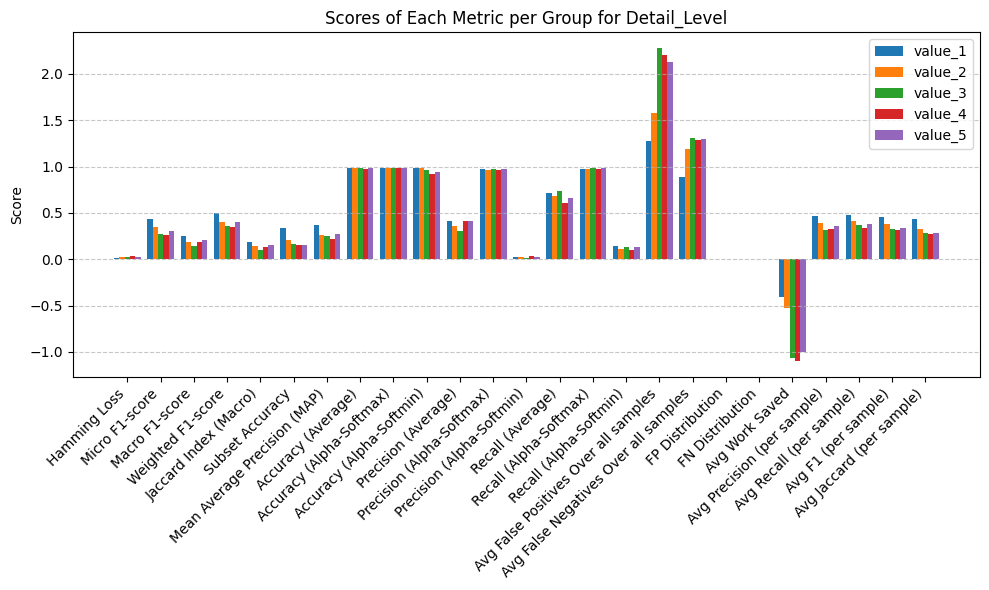

The meta data we check is :  Enumeration


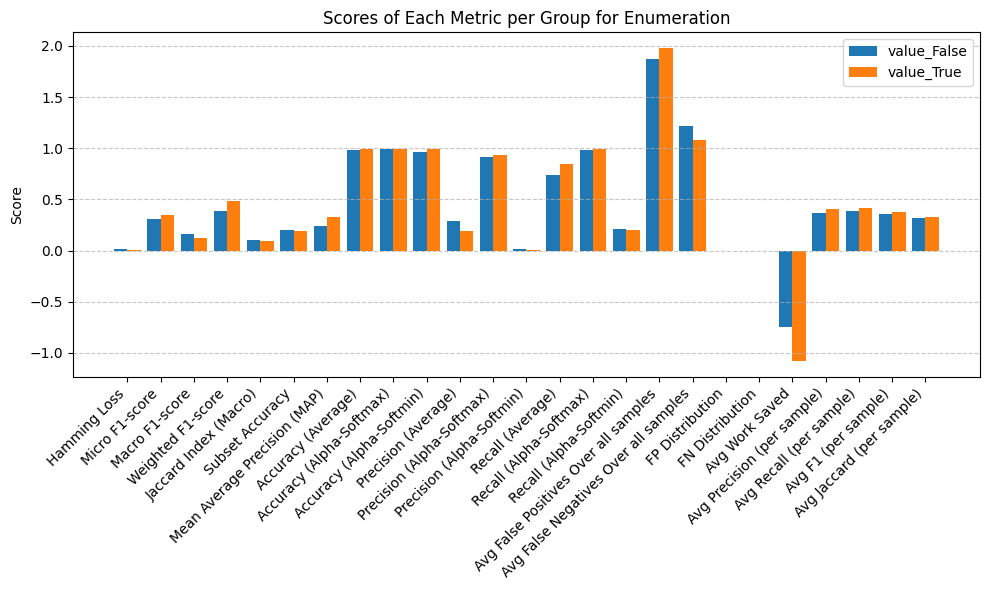

The meta data we check is :  Explicit_Symptom


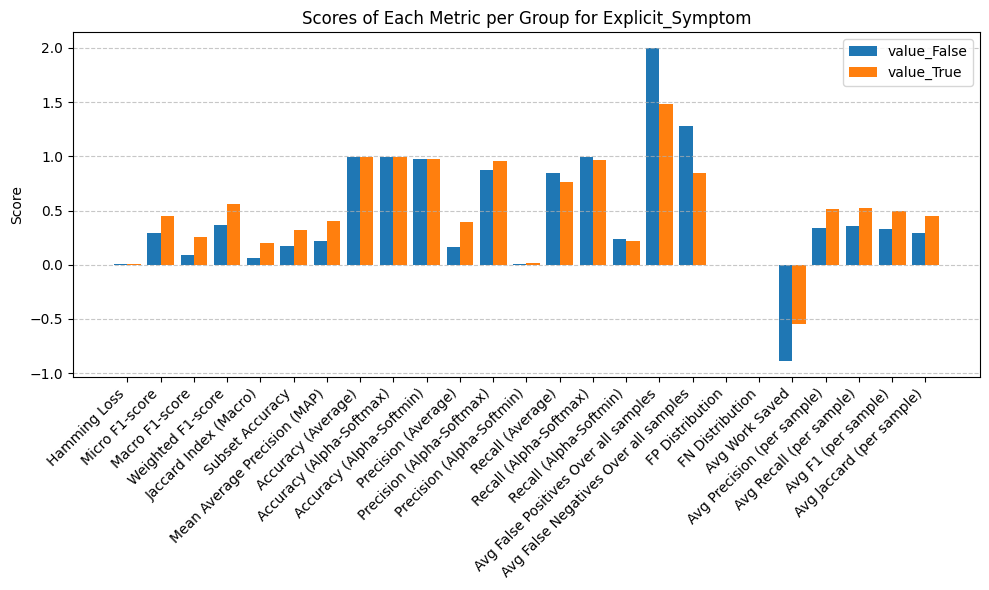

The meta data we check is :  Spelling_Errors


Running the evaluation sensibility for  multi_poisson_correl  and prompting method :  zero_shot
The meta data we check is :  Language_Style


The meta data we check is :  Tone


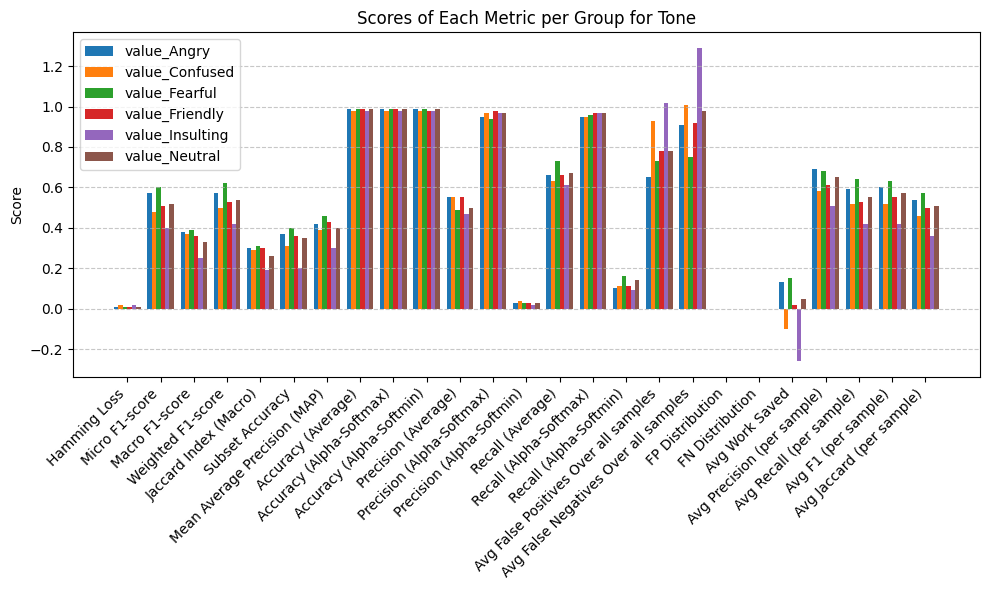

The meta data we check is :  Detail_Level


The meta data we check is :  Enumeration


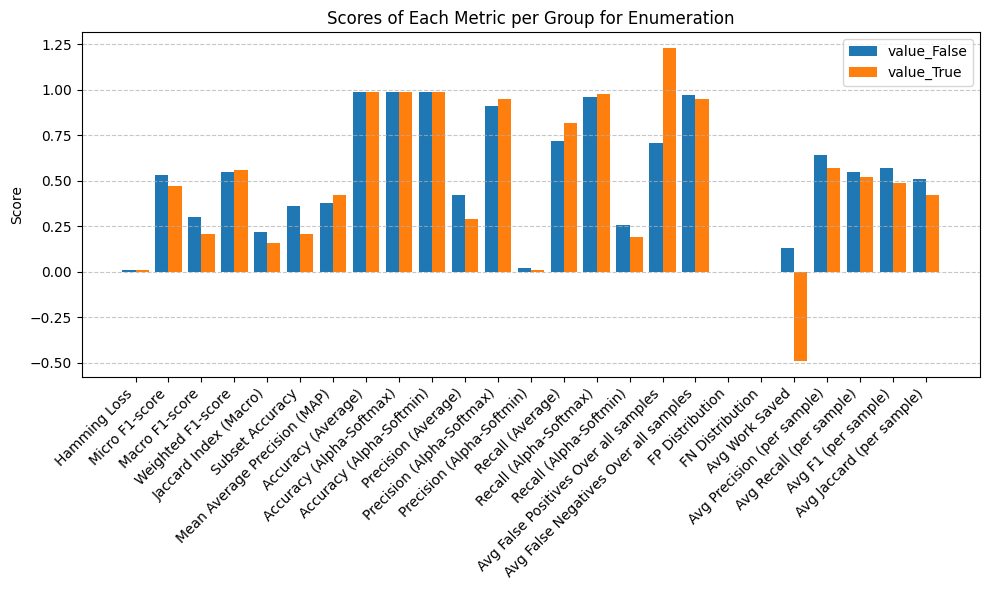

The meta data we check is :  Explicit_Symptom


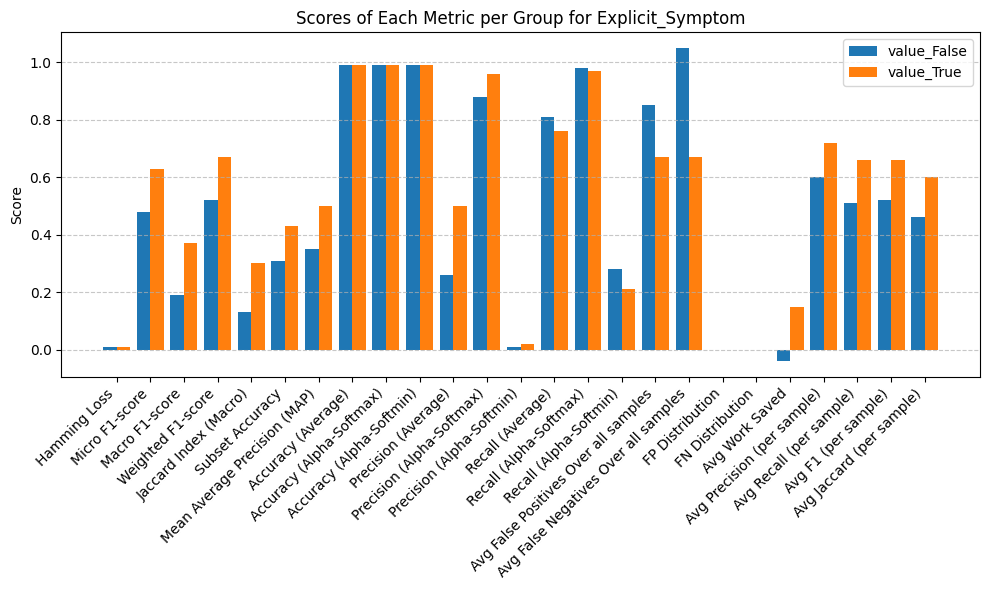

The meta data we check is :  Spelling_Errors


Running the evaluation sensibility for  multi_poisson_correl  and prompting method :  few_shot
The meta data we check is :  Language_Style


The meta data we check is :  Tone


The meta data we check is :  Detail_Level


The meta data we check is :  Enumeration


The meta data we check is :  Explicit_Symptom


The meta data we check is :  Spelling_Errors


Running the evaluation sensibility for  multi_poisson_correl  and prompting method :  chain_of_thought
The meta data we check is :  Language_Style


The meta data we check is :  Tone


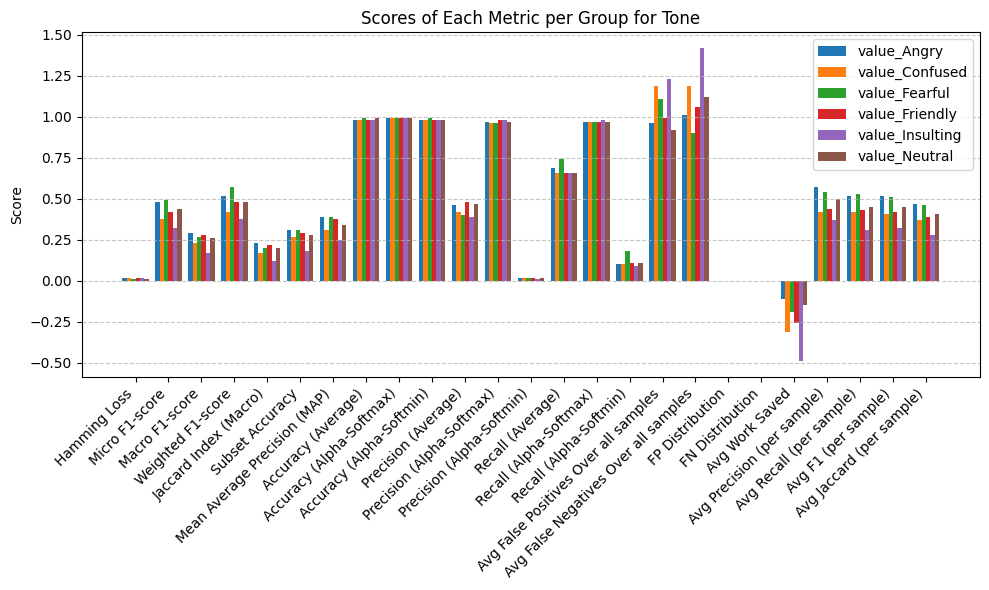

The meta data we check is :  Detail_Level


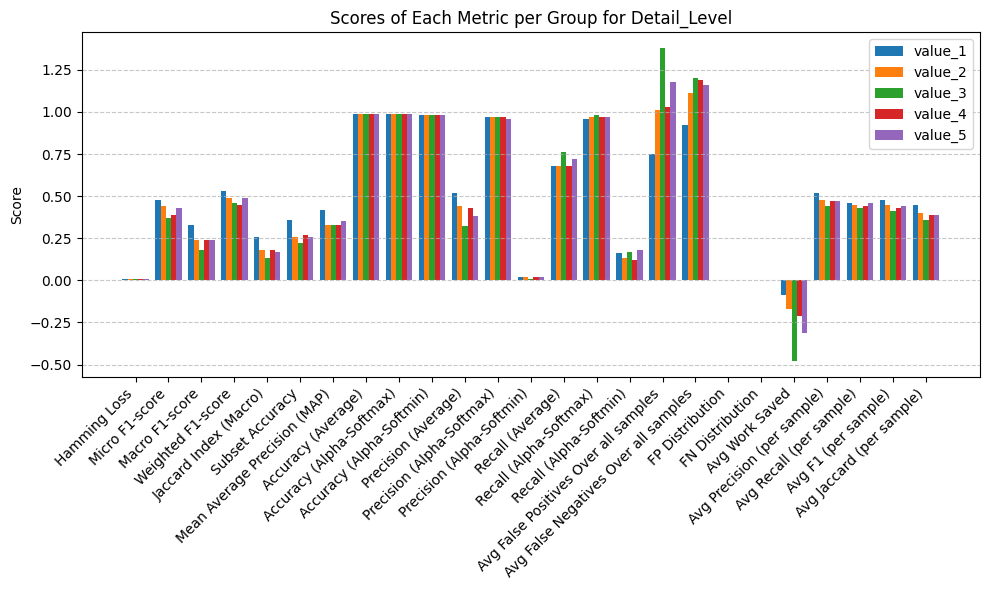

The meta data we check is :  Enumeration


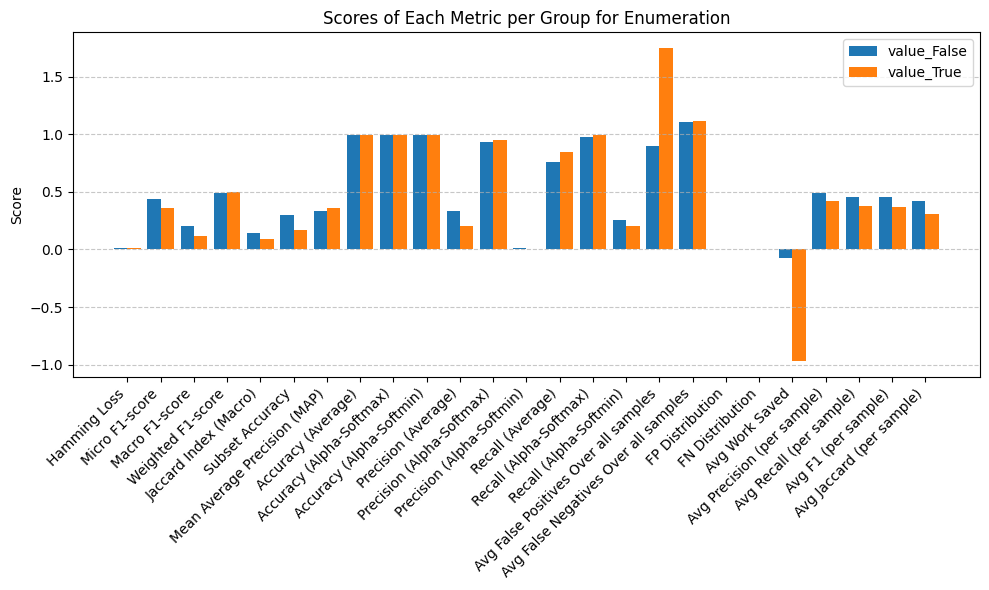

The meta data we check is :  Explicit_Symptom


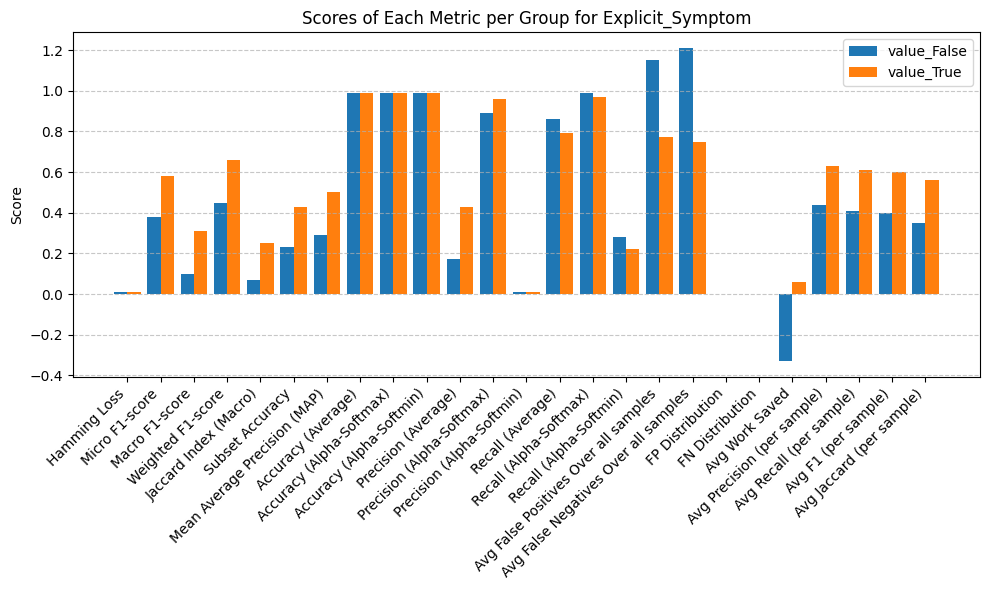

The meta data we check is :  Spelling_Errors


Running the evaluation sensibility for  multi_poisson_correl  and prompting method :  self_refinement
The meta data we check is :  Language_Style


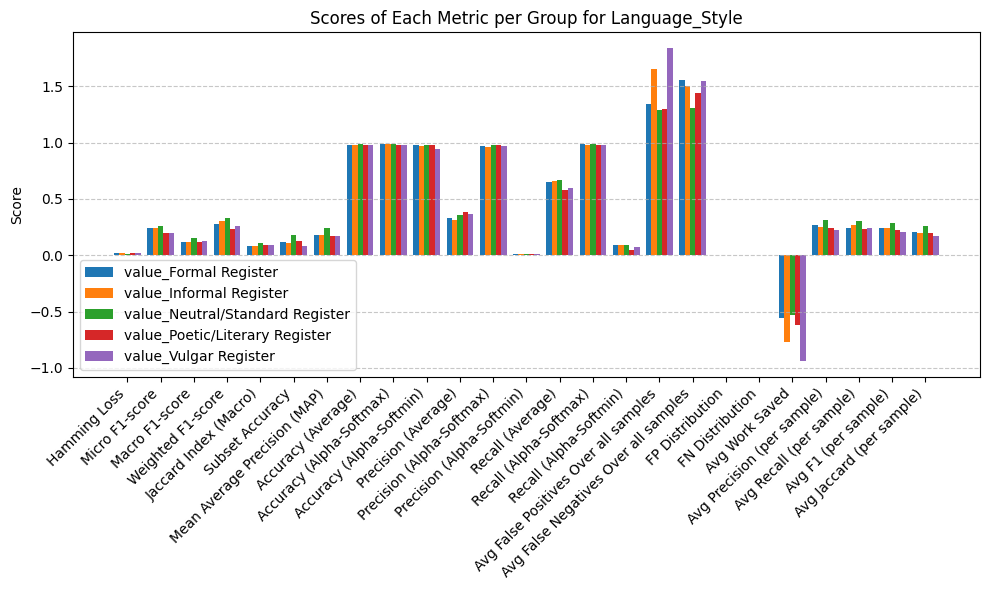

The meta data we check is :  Tone


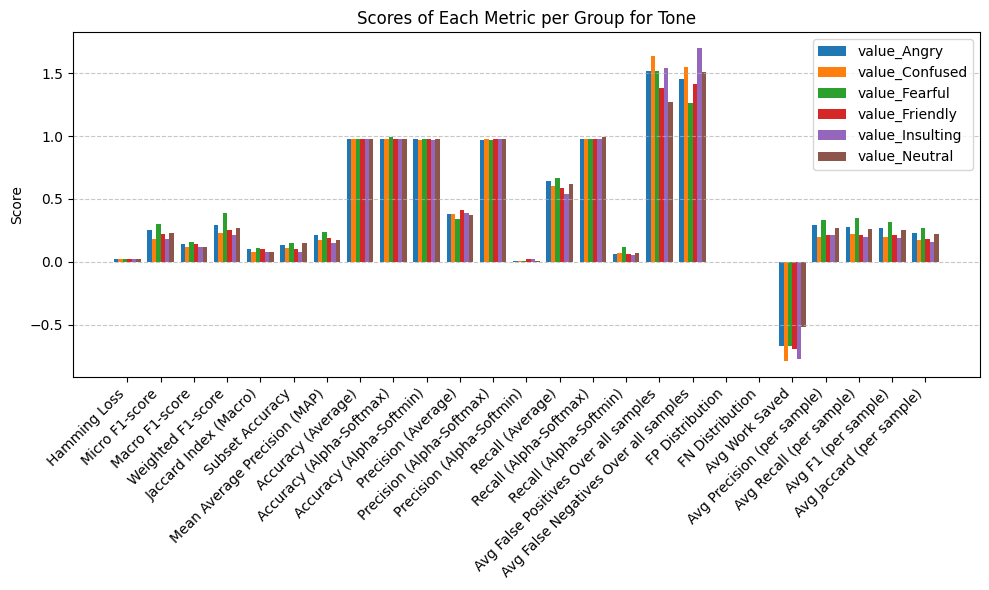

The meta data we check is :  Detail_Level


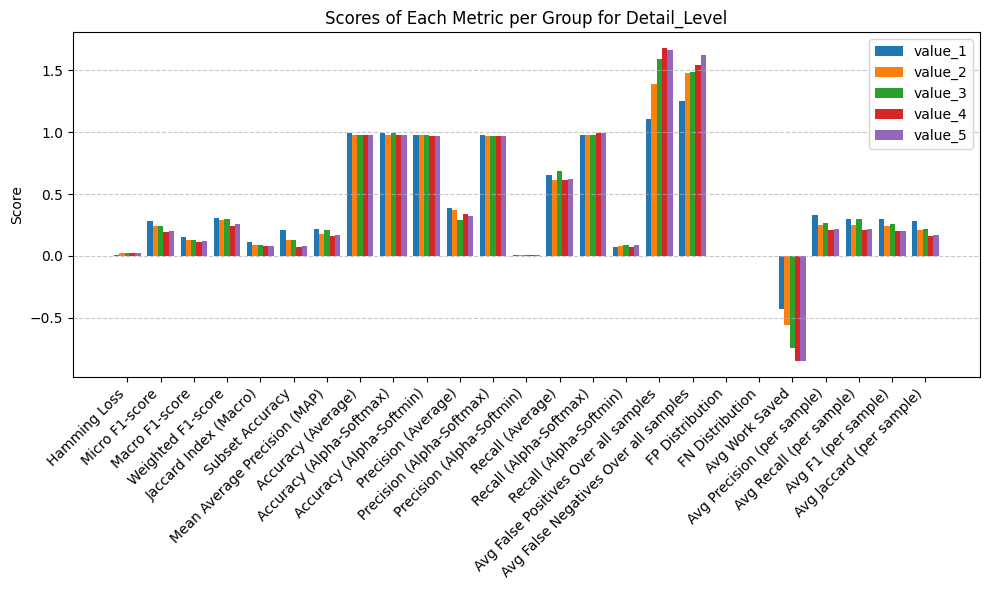

The meta data we check is :  Enumeration


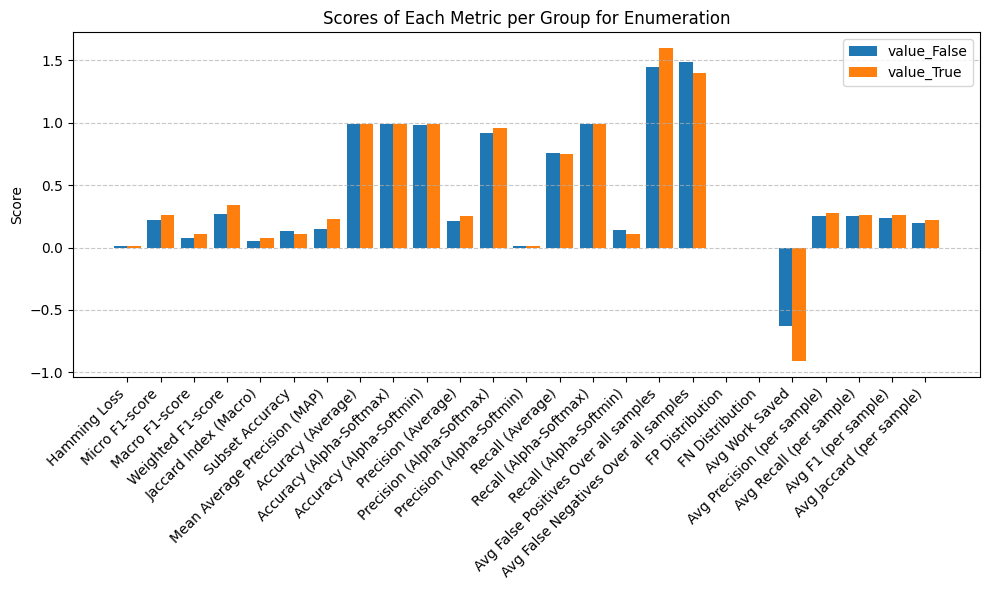

The meta data we check is :  Explicit_Symptom


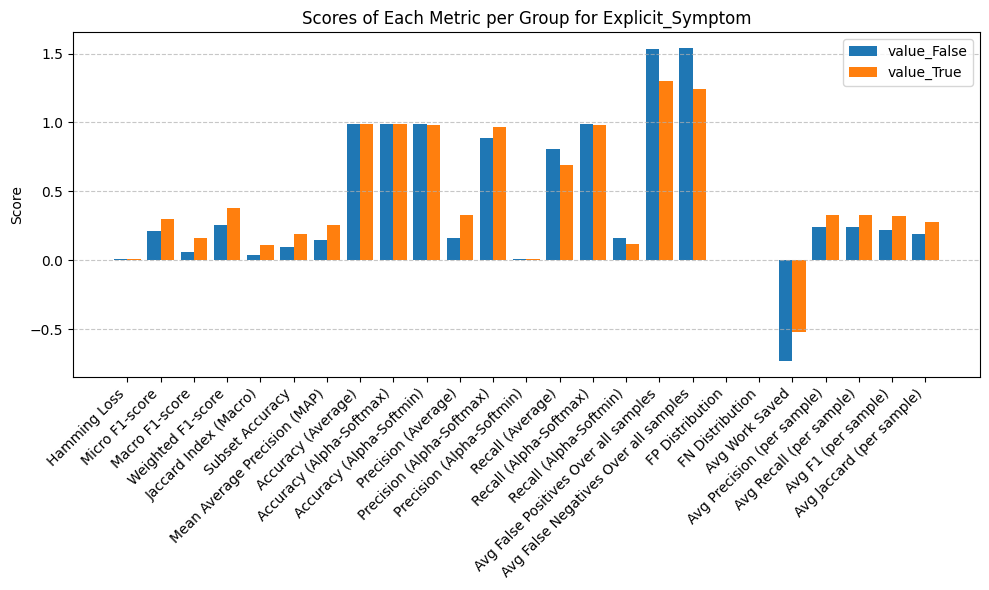

The meta data we check is :  Spelling_Errors


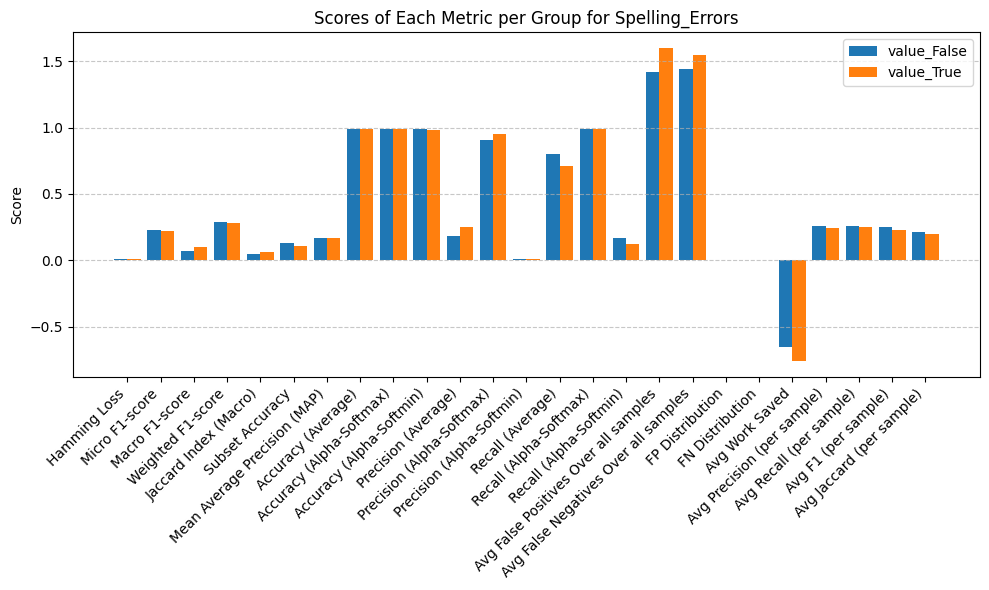

Running the evaluation sensibility for  multi_poisson_correl  and prompting method :  multiple_demonstrations
The meta data we check is :  Language_Style


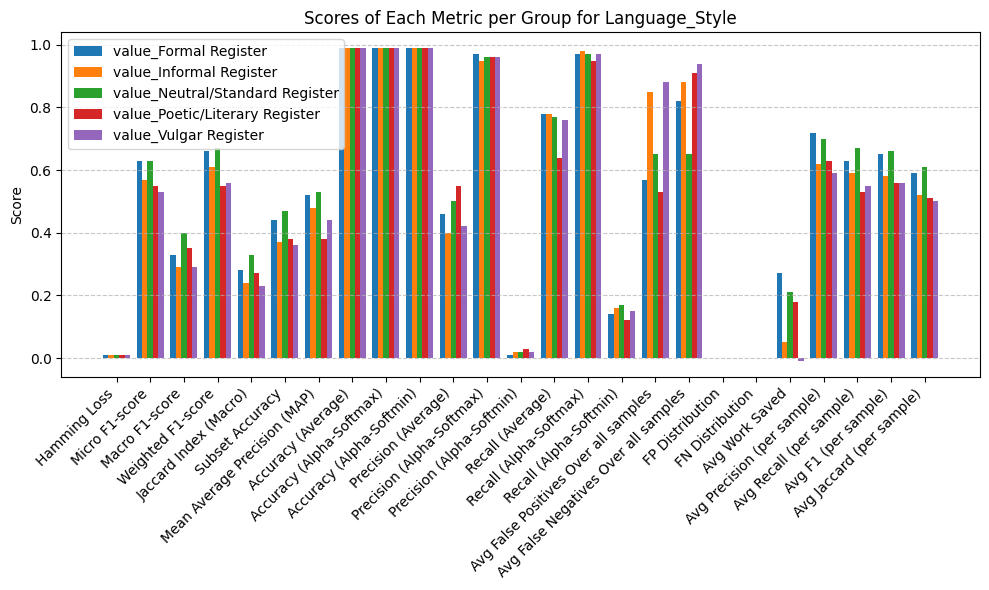

The meta data we check is :  Tone


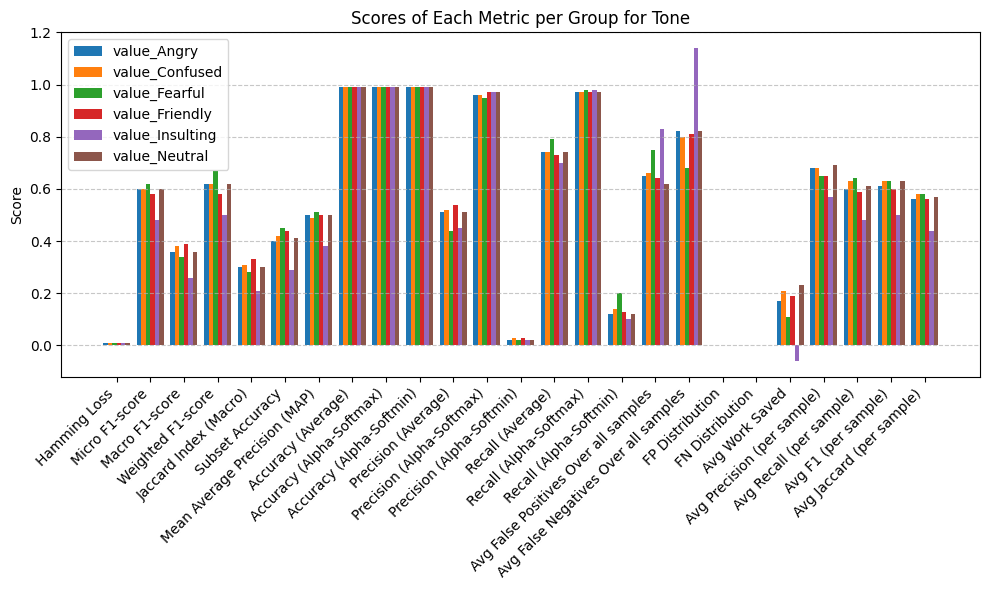

The meta data we check is :  Detail_Level


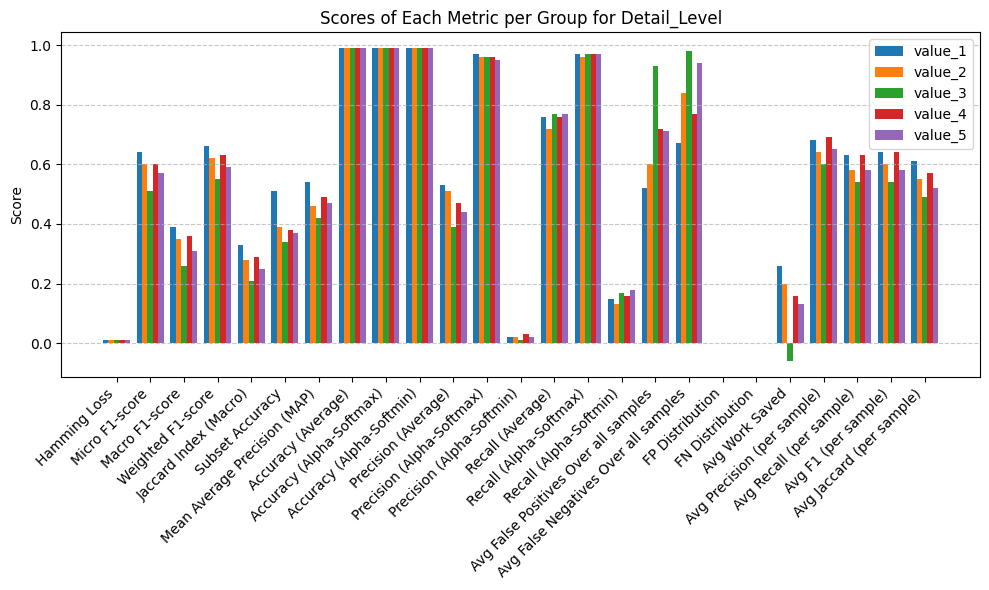

The meta data we check is :  Enumeration


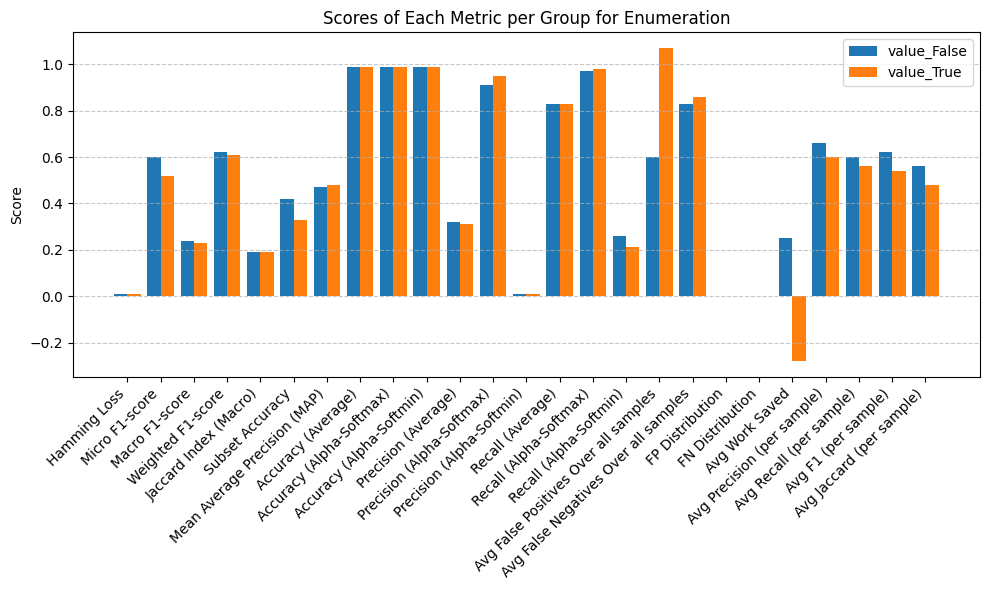

The meta data we check is :  Explicit_Symptom


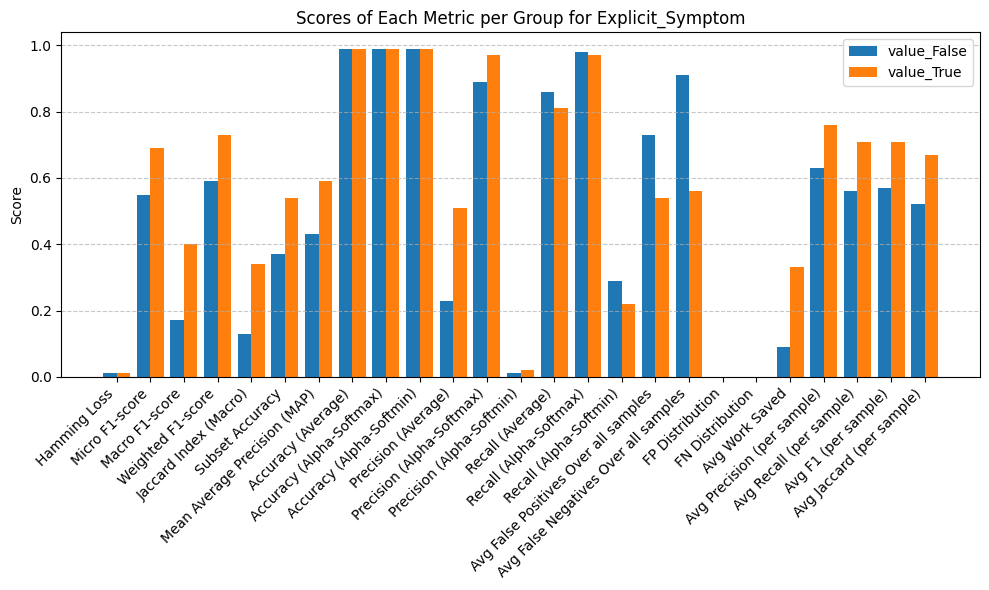

The meta data we check is :  Spelling_Errors


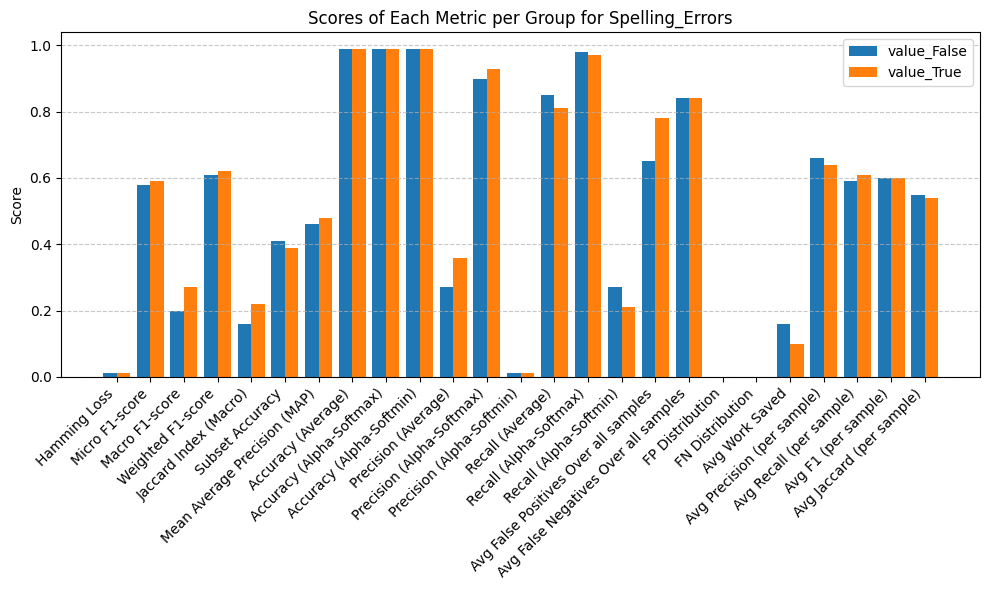

In [7]:
import pandas as pd
from transformers import pipeline
from extracting_prompt import ExtractingPrompt
from LLM import LLM
from tqdm import tqdm
import re
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, accuracy_score, 
    precision_score, recall_score, hamming_loss, f1_score, jaccard_score, 
    average_precision_score
)
from evaluation_global import Evaluation_pipeline
import warnings
warnings.filterwarnings('ignore')


# Helper to convert cell to float if possible
def safe_to_float(x):
    try:
        # If it's a list, try to extract the first element
        if isinstance(x, list) and len(x) == 1:
            return float(x[0])
        elif isinstance(x, (int, float, np.float64)):
            return x
        else:
            return float(x)
    except:
        return np.nan  # mark as missing if not convertible
    
metadatas = ["Language_Style", "Tone", "Detail_Level", "Enumeration", "Explicit_Symptom", "Spelling_Errors"]




df_onesymptom = pd.read_csv(r'dataset_generated_one_symptom_per_phrase.csv')
df_onesymptom.rename(columns={"symptom": "Symptoms"}, inplace=True)

df_multi_predef = pd.read_csv(r'dataset_generated_multiple_symptoms_per_phrase_predefined_distrib.csv')
df_multi_poisson = pd.read_csv(r'dataset_generated_multiple_symptoms_per_phrase_poisson_distrib.csv')

df_multi_poisson_correl = pd.read_csv(r'dataset_generated_multiple_symptom_per_phrase_poisson_correlations.csv')


df_lists = {"multi_poisson_correl" : df_multi_poisson_correl,
            #  "multi_poisson" : df_multi_poisson, 
            #  "multi_predef": df_multi_predef, 
             }


prompting_methods = [
    "explicit",
    "zero_shot",
    "few_shot",
    "chain_of_thought",
    "self_refinement",
    "multiple_demonstrations"
]


# paths = [r'dataset_extracting_multi_poisson_correl_explicit.csv',
#         ]

# paths2 = [r'../old_code/dataset_generated_multiple_symptom_per_phrase_poisson_correlations.csv',
# #          r'../old_code/dataset_generated_one_symptom_per_phrase.csv',
# #          r'../old_code/dataset_generated_multiple_symptoms_per_phrase_predefined_distrib.csv',
# #          r'../old_code/dataset_generated_multiple_symptoms_per_phrase_poisson_distrib.csv',       
# # ]


for el,df in df_lists.items():

    for method in prompting_methods:

            path = f'dataset_extracting_{el}_{method}.csv'
            data_generated = df

            print('Running the evaluation sensibility for ', el,' and prompting method : ', method)


            df_extracted = pd.read_csv(r'./'+path)
        
            df_extracted['Extracted_Symptom'] = df_extracted['Extracted_Symptom'].apply(lambda x: [s.strip() for s in str(x).split(',')])
            df_extracted['Extracted_Symptom'] = df_extracted['Extracted_Symptom'].apply(lambda lst: str(lst))

            
            merged_df = pd.merge(df_extracted, data_generated, left_on='Dialogue', right_on='Dialogue_Generated')

                
            final_df = {}

            for metadata in metadatas : 

                print('The meta data we check is : ' , metadata)
                list_all = []
                grouped = merged_df.groupby(metadata)
                for group_name, group_df in grouped:
                    
                    eval_df = Evaluation_pipeline(group_df)
                    
                    list_all.append(eval_df[['metric', 'value']].set_index('metric').rename(columns={'value': f'value_{group_name}'}))

                final_df[metadata] = pd.concat(list_all, axis=1).reset_index()

                df_plot = final_df[metadata]
                
                # Apply the cleaning
                for col in df_plot.columns[1:]:
                    df_plot[col] = df_plot[col].apply(safe_to_float)



                metrics = df_plot['metric'].values
                group_columns = df_plot.columns[1:]
                x = np.arange(len(metrics))
                width = 0.8 / len(group_columns)

                fig, ax = plt.subplots(figsize=(10, 6))

                for i, group in enumerate(group_columns):
                    offset = (i - (len(group_columns) - 1) / 2) * width
                    y_values = df_plot[group].values.astype(float)
                    ax.bar(x + offset, y_values, width, label=group)

                ax.set_xticks(x)
                ax.set_xticklabels(metrics, rotation=45, ha='right')
                ax.set_ylabel('Score')
                ax.set_title(f'Scores of Each Metric per Group for {metadata}')
                ax.legend()
                ax.grid(True, axis='y', linestyle='--', alpha=0.7)

                plt.tight_layout()
                plt.show()

In [5]:
data_generated

Dialogue_Generated  \
0    "I'm havin some issues, I got pain with the, u...   
1    "Oh no, I'm freaking out, I've been having the...   
2    "I've got this crazy dry mouth that's like sup...   
3    "As I wander through the twilight realm of my ...   
4    "I'm stuck with mild constipation, it's bloody...   
..                                                 ...   
995  "I am experiencing a change in my usuall urine...   
996  "I'm experiencing a change in my urine color, ...   
997  "The patient's condition is characterised by t...   
998  "These mouth/throat sores are an absolute nuis...   
999  "Mild afflictions beset my mouth and throat, s...   

                                              Symptoms  \
0    ['Pain with sexual intercourse', 'Nail discolo...   
1    ['Nosebleed', 'Urinary incontinence', 'Constip...   
2    ['Dry Mouth', 'Cracking at the corners of the ...   
3    ['Achieve and maintain erection', 'Increased s...   
4                                     ['Constipation']   
..                                                 ...   
995  ['Change in usual urine color', 'Joint pain', ...   
996  ['Change in usual urine color', 'Nail loss', '...   
997                     ['Vaginal dryness', 'Fatigue']   
998                             ['Mouth/throat sores']   
999          ['Mouth/throat sores', 'Urinary urgency']   

                                           Description  \
0    Pain with sexual intercourse (attributes: Seve...   
1    Nosebleed (attributes: Frequency, Severity); U...   
2    Dry Mouth (attributes: Severity); Cracking at ...   
3    Achieve and maintain erection (attributes: Sev...   
4                  Constipation (attributes: Severity)   
..                                                 ...   
995  Change in usual urine color (attributes: Prese...   
996  Change in usual urine color (attributes: Prese...   
997  Vaginal dryness (attributes: Severity); Fatigu...   
998  Mouth/throat sores (attributes: Interference (...   
999  Mouth/throat sores (attributes: Interference (...   

                                                  Meta  \
0    Pain with sexual intercourse -> Severity: Pref...   
1    Nosebleed -> Frequency: Occasionally, Severity...   
2    Dry Mouth -> Severity: Very severe; Cracking a...   
3    Achieve and maintain erection -> Severity: Mil...   
4                       Constipation -> Severity: Mild   
..                                                 ...   
995  Change in usual urine color -> Presence/Absenc...   
996  Change in usual urine color -> Presence/Absenc...   
997  Vaginal dryness -> Severity: Not applicable; F...   
998  Mouth/throat sores -> Interference (with daily...   
999  Mouth/throat sores -> Interference (with daily...   

                Language_Style      Tone  Detail_Level  Enumeration  \
0              Vulgar Register  Confused             1        False   
1            Informal Register   Fearful             2        False   
2            Informal Register   Fearful             3        False   
3     Poetic/Literary Register  Confused             3        False   
4            Informal Register     Angry             1        False   
..                         ...       ...           ...          ...   
995            Formal Register   Neutral             2        False   
996  Neutral/Standard Register   Neutral             4        False   
997            Formal Register   Neutral             5        False   
998            Formal Register     Angry             1        False   
999   Poetic/Literary Register   Neutral             1        False   

     Explicit_Symptom  Spelling_Errors  
0                True            False  
1               False            False  
2               False             True  
3               False            False  
4                True            False  
..                ...              ...  
995              True             True  
996             False            False  
997             False     